In [16]:
import weightwatcher as ww
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pickle
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

block_size = 128
batch_size = 64
max_iters = 1000
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_layer = 8
n_head = 8
dropout = 0.2

vocab_size = 32171

Device: cuda


In [17]:
def analyze_model_weights(model):
    # Initialize weightwatcher
    watcher = ww.WeightWatcher(model=model)
    
    # Get detailed analysis
    print("\nAnalyzing model weights...")
    details = watcher.analyze(min_evals=50, plot=True)
    
    # Print detailed layer analysis
    print("\nDetailed Layer Analysis:")
    print(details)  # This is a pandas DataFrame
    
    # Get summary metrics
    summary = watcher.get_summary(details)
    print("\nModel Summary Metrics:")
    print("Log Norm:", summary['log_norm'])
    print("Alpha:", summary['alpha'])
    print("Alpha Weighted:", summary['alpha_weighted'])
    print("Log Alpha Norm:", summary['log_alpha_norm'])
    print("Log Spectral Norm:", summary['log_spectral_norm'])
    print("Stable Rank:", summary['stable_rank'])
    print("MP Softrank:", summary['mp_softrank'])
    
    # Get Empirical Spectral Density (ESD)
    esd = watcher.get_ESD()
    if esd is not None:
        print("\nEmpirical Spectral Density available")
    
    return details, summary

In [18]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out



class MultiHeadAttention(nn.Module):
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)
        elif isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, index, targets=None):

        B, T = index.shape

        tok_emb = self.token_embedding_table(index)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index
    
model = GPTLanguageModel(vocab_size)
print("Loading previously trained parameters...")
with open("data/models/model-04-reddit_text.pkl", 'rb') as f:
    model = pickle.load(f)
print("Model loaded.")
m = model.to(device)

Loading previously trained parameters...
Model loaded.



Analyzing model weights...


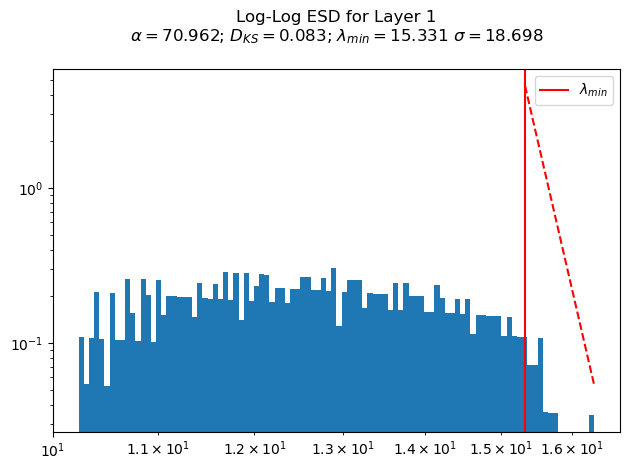

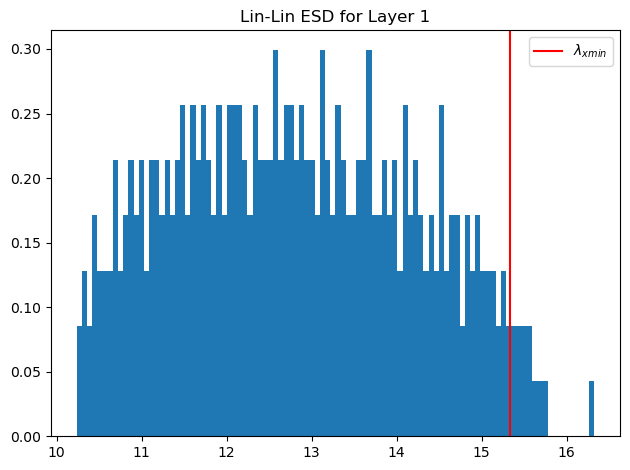

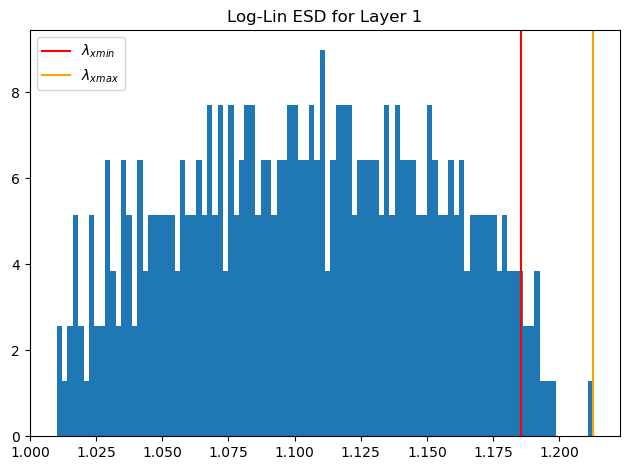

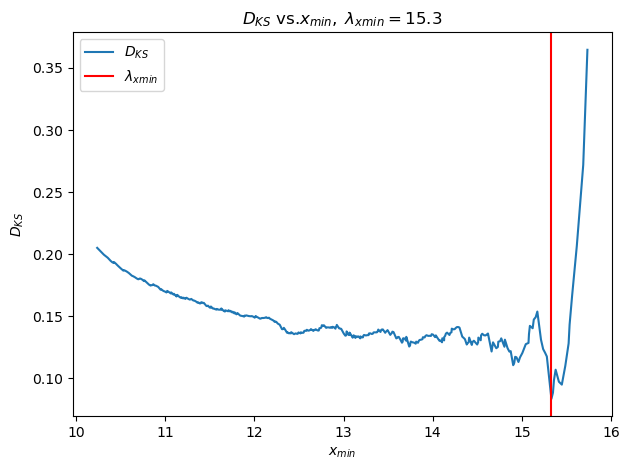

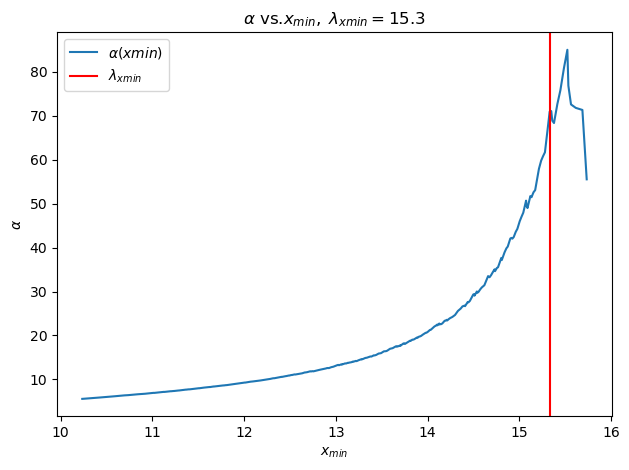

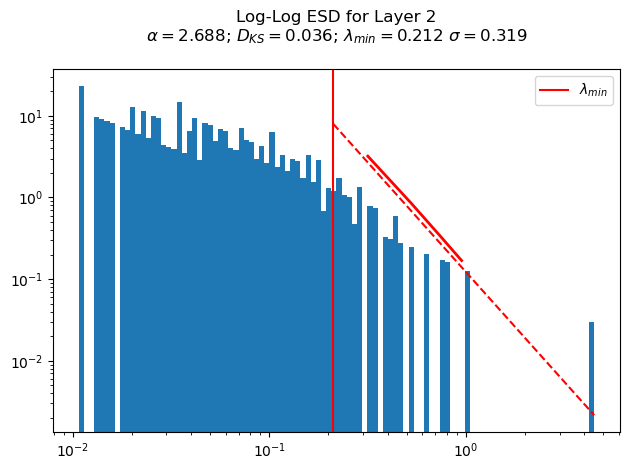

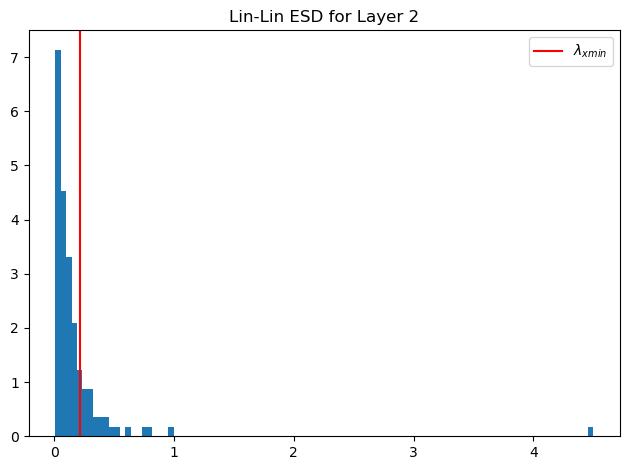

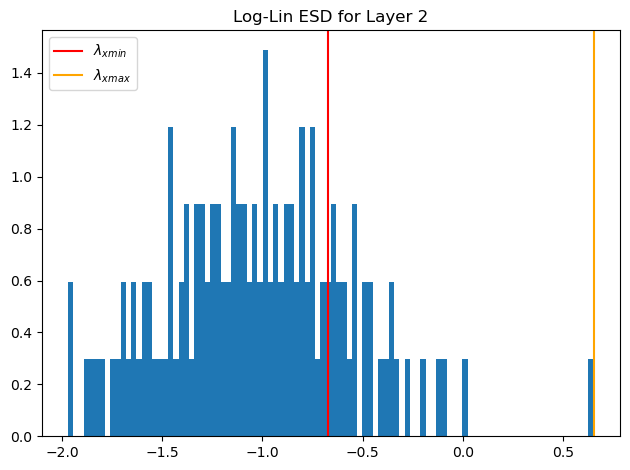

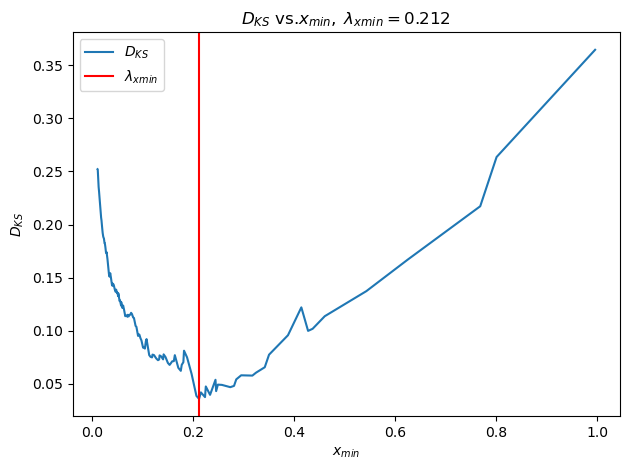

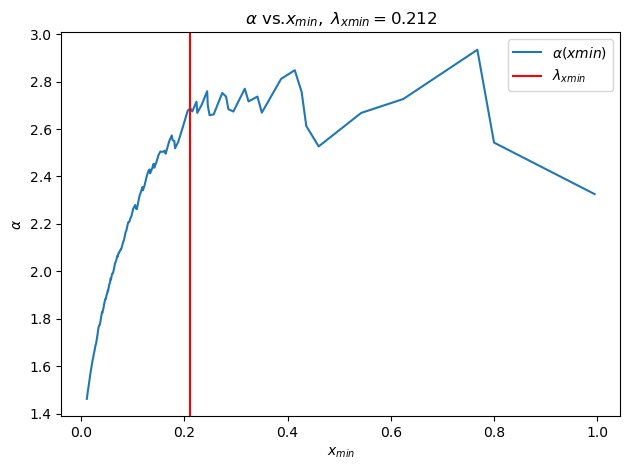

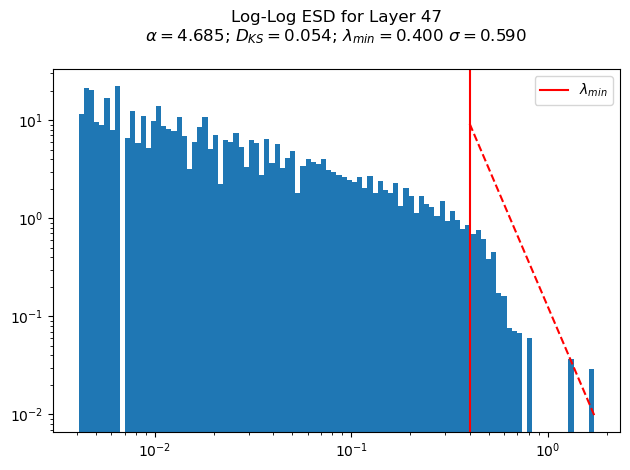

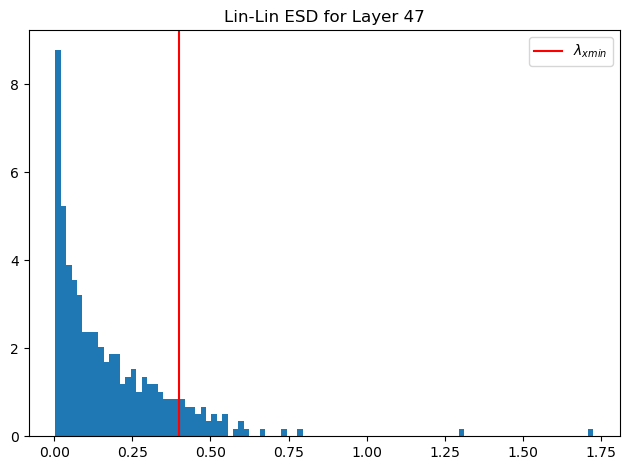

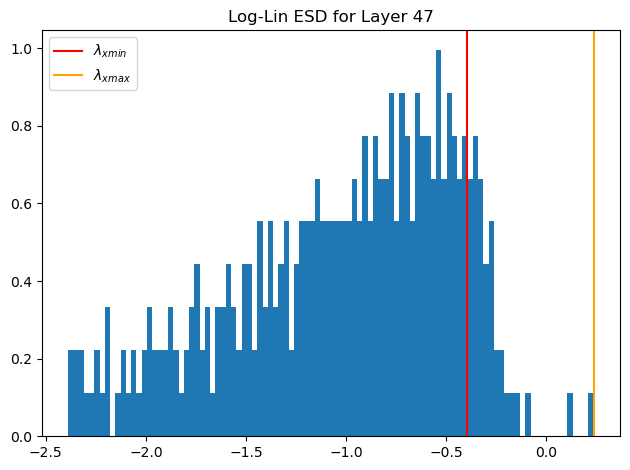

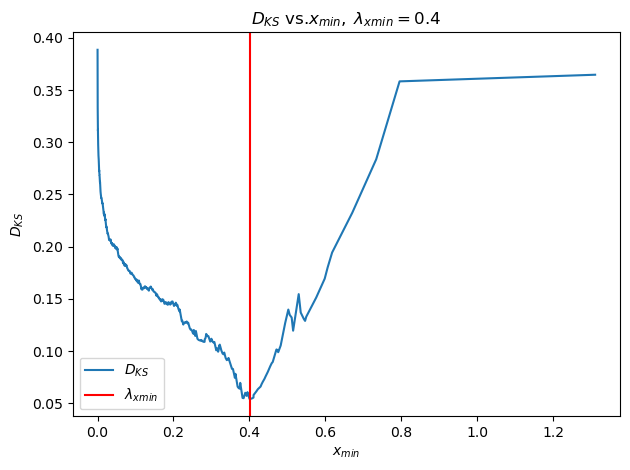

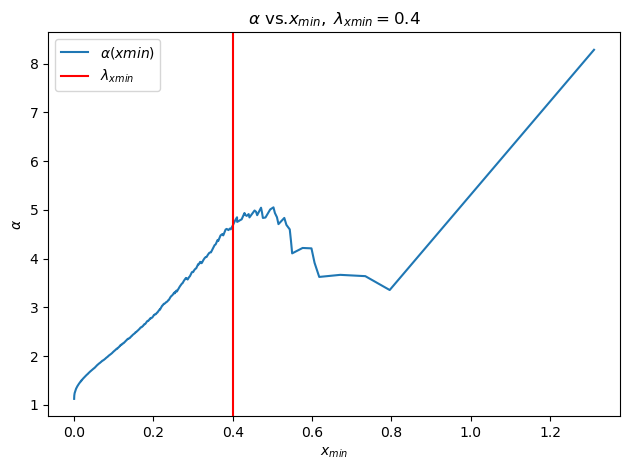

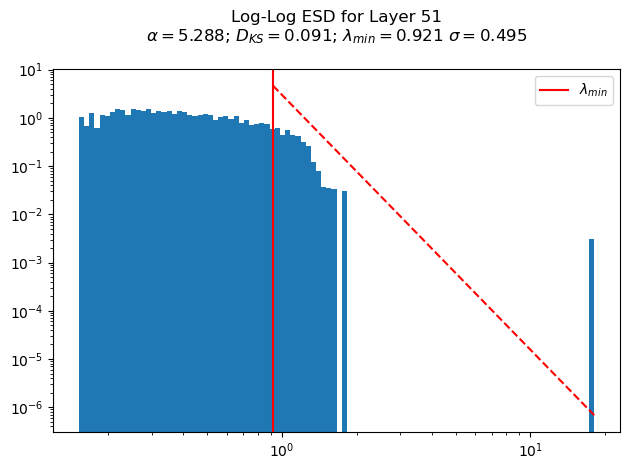

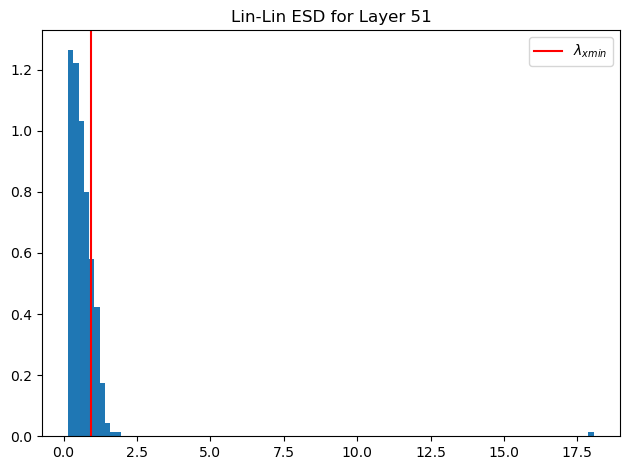

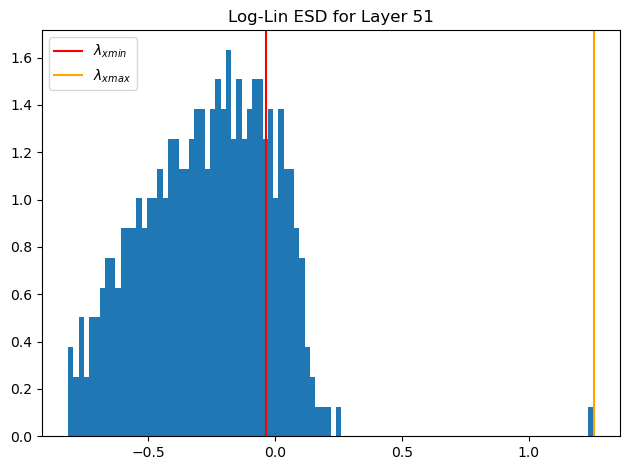

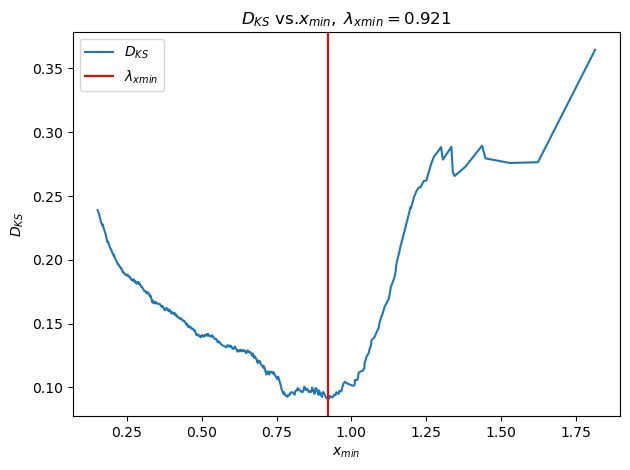

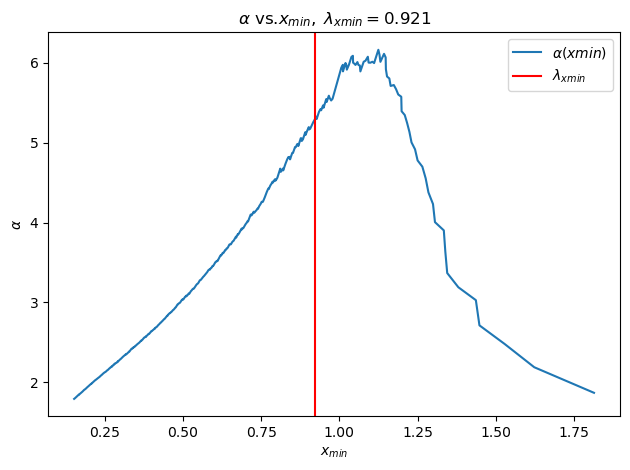

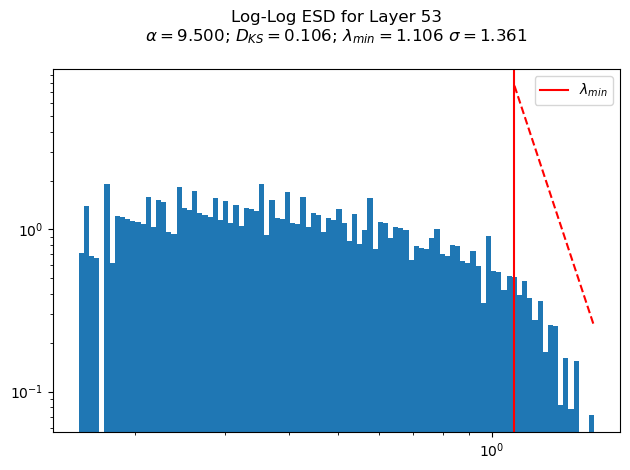

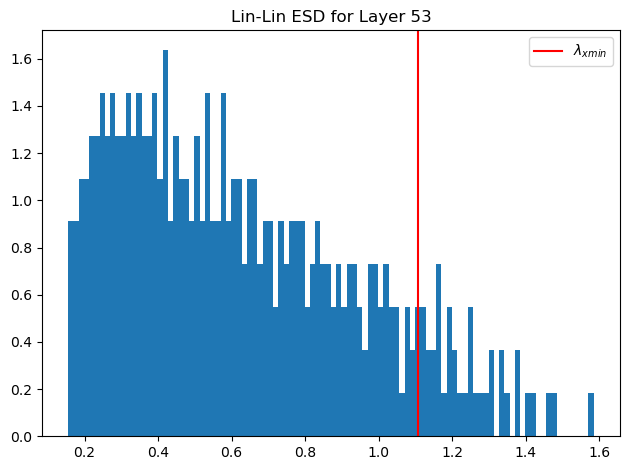

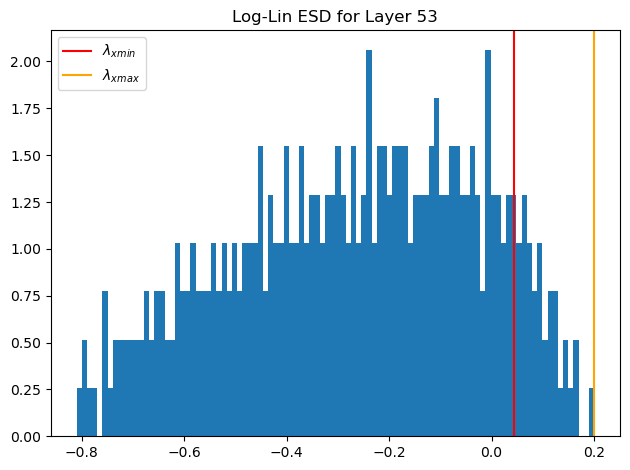

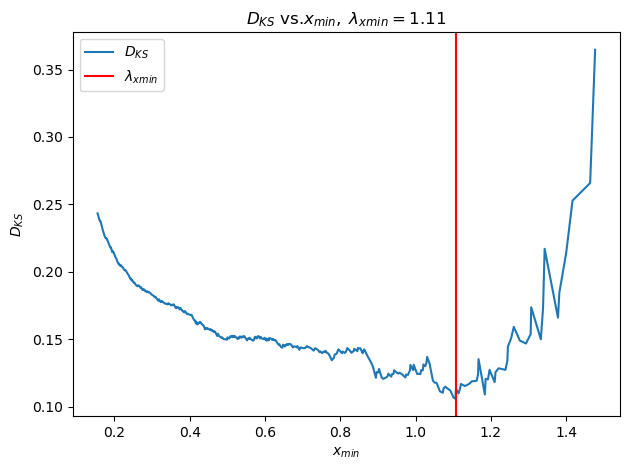

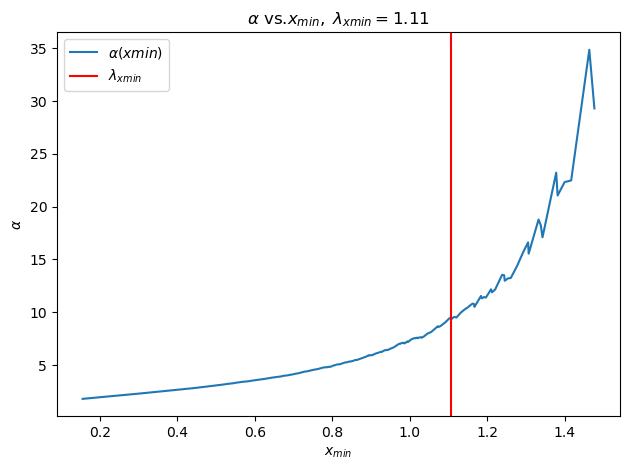

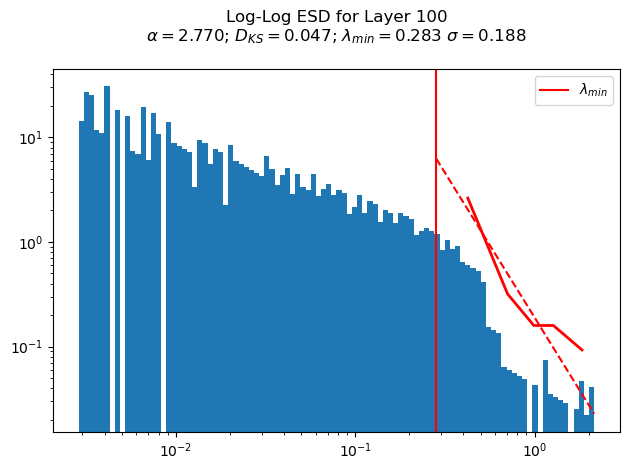

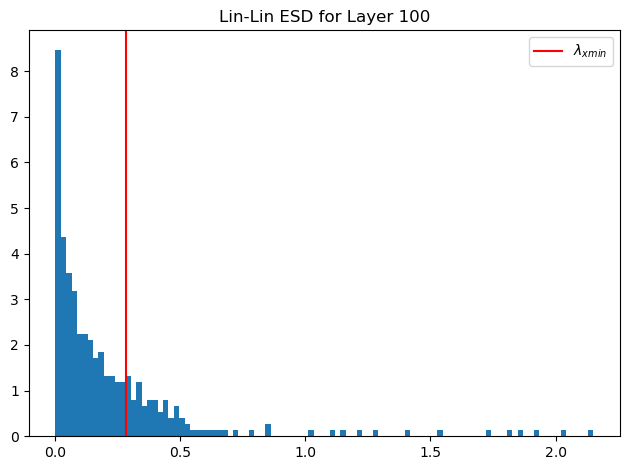

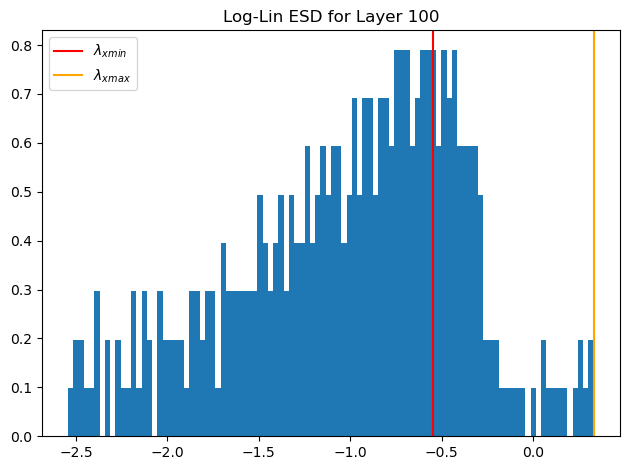

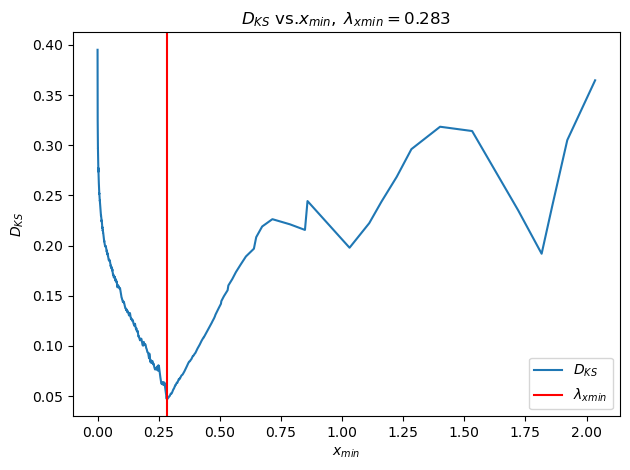

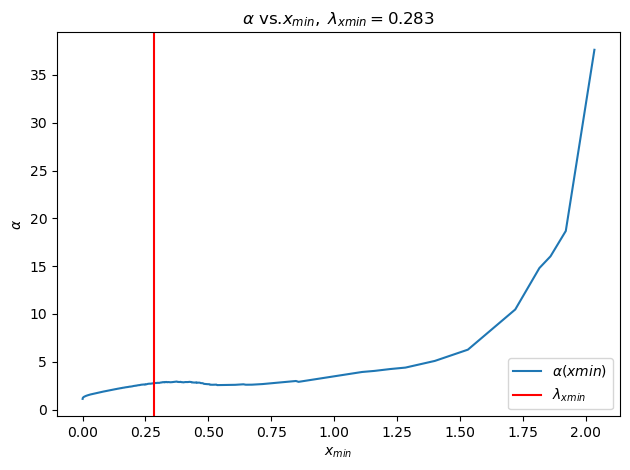

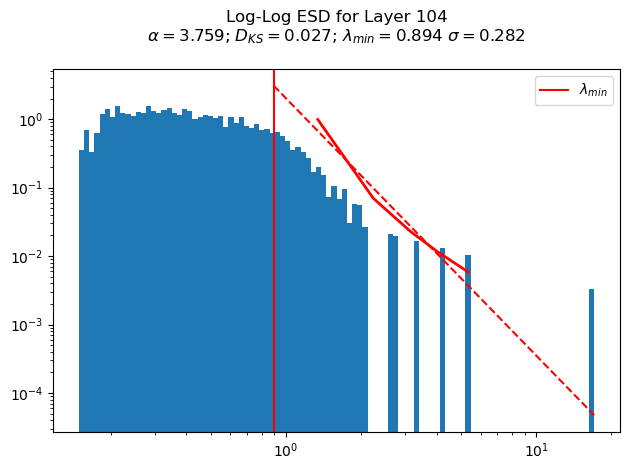

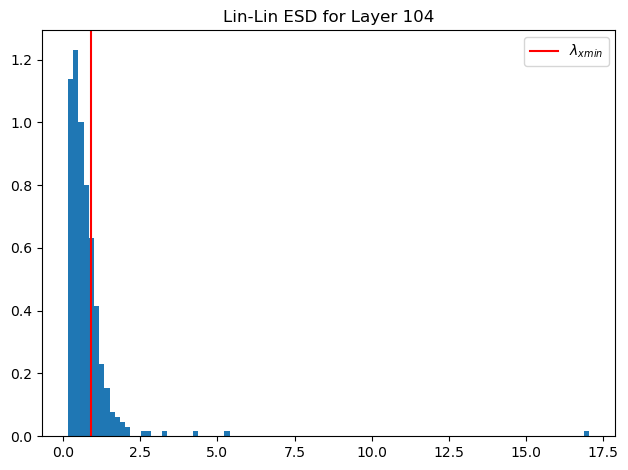

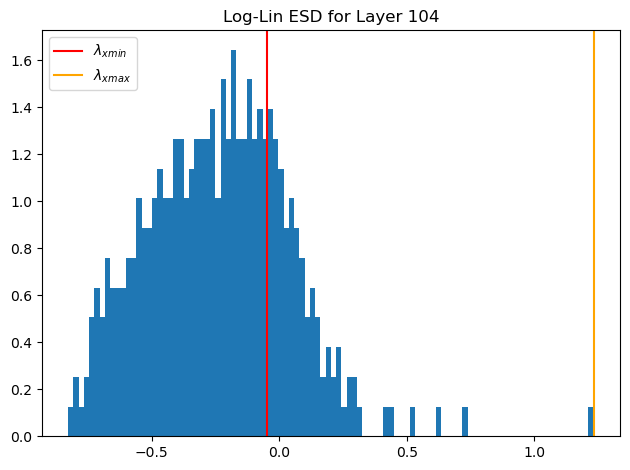

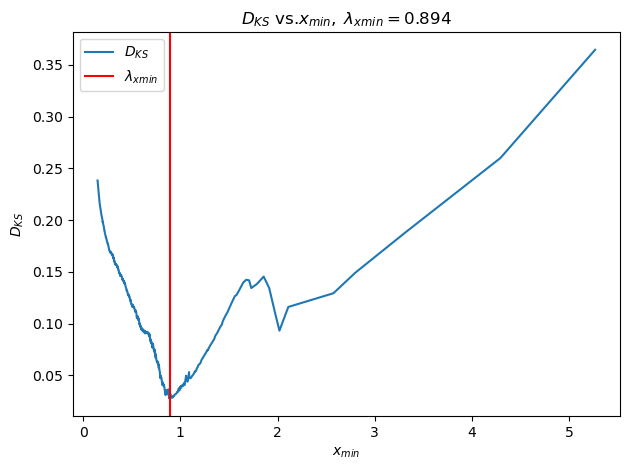

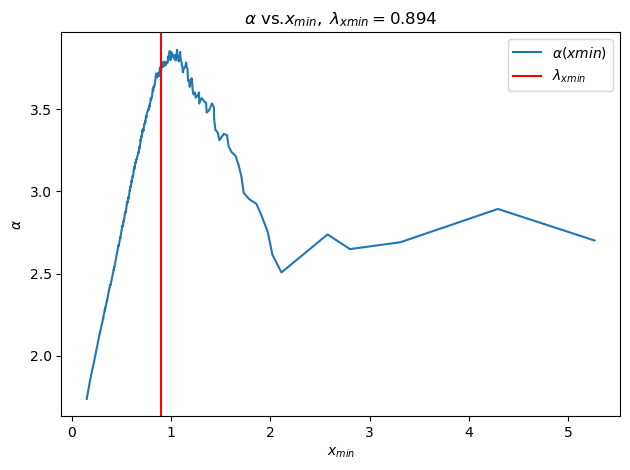

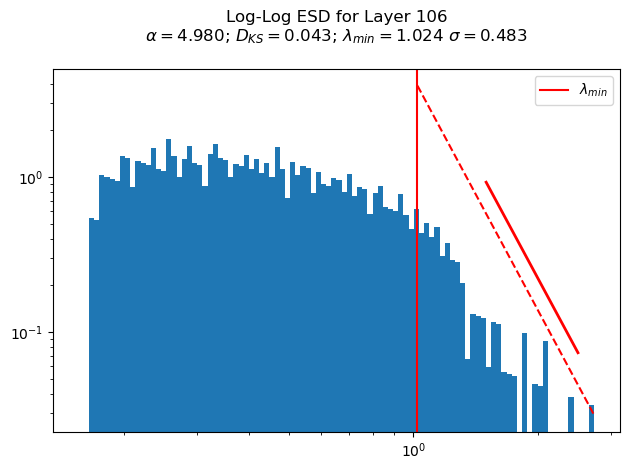

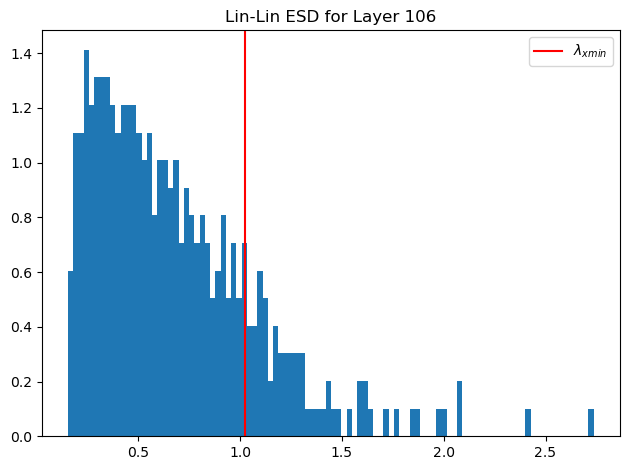

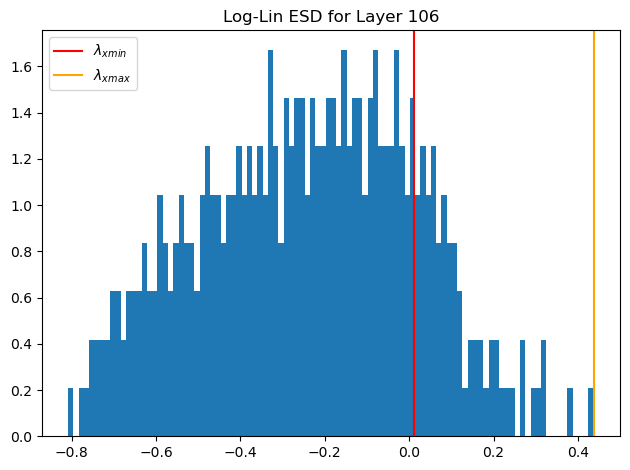

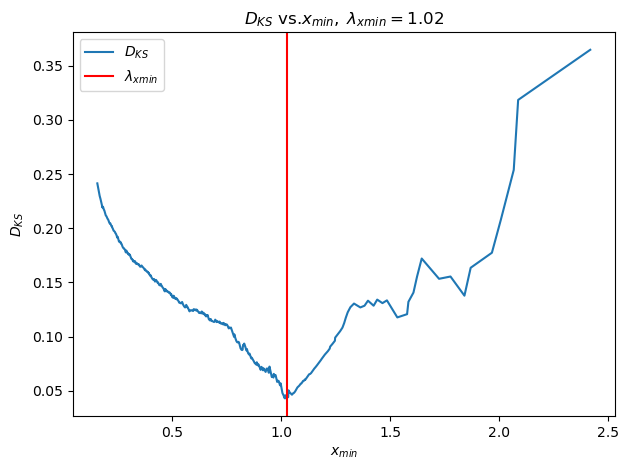

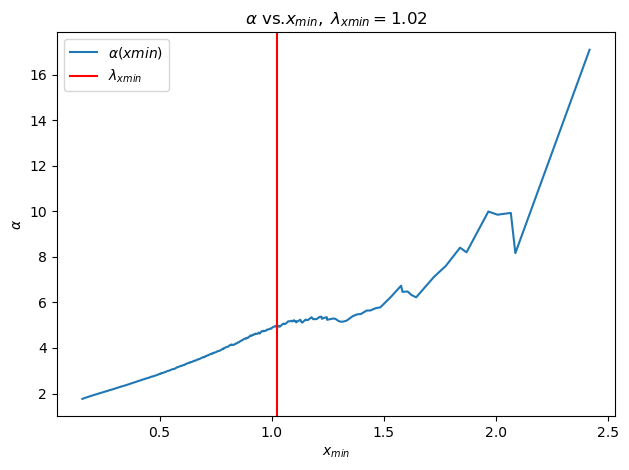

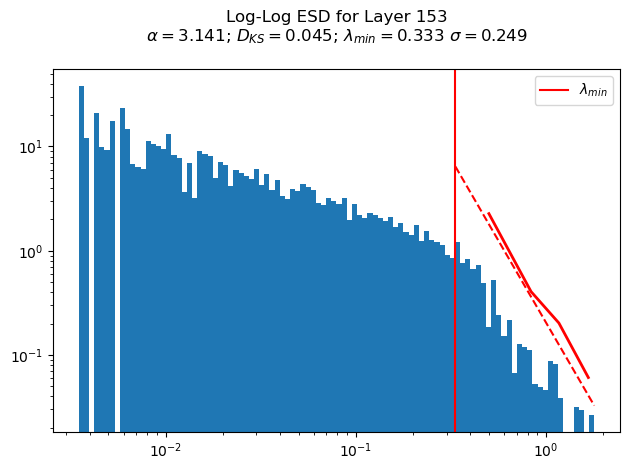

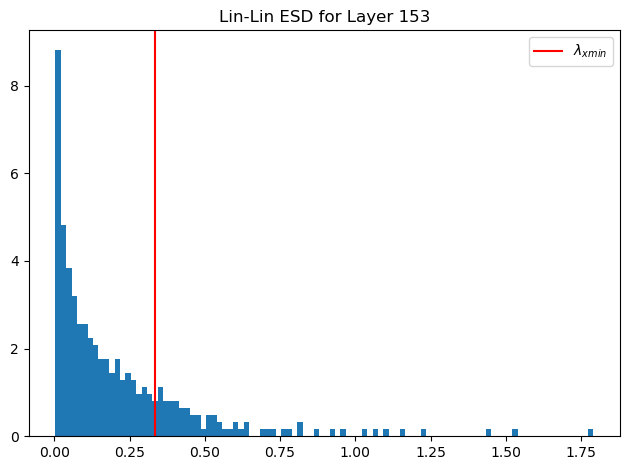

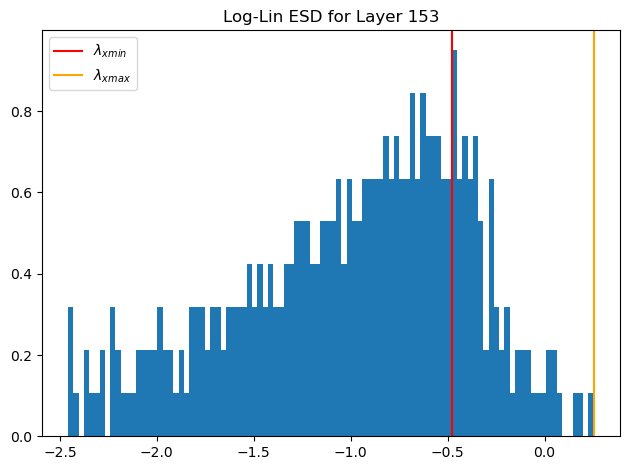

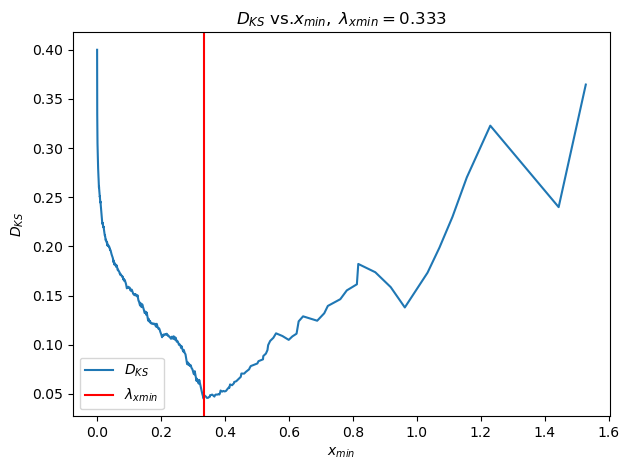

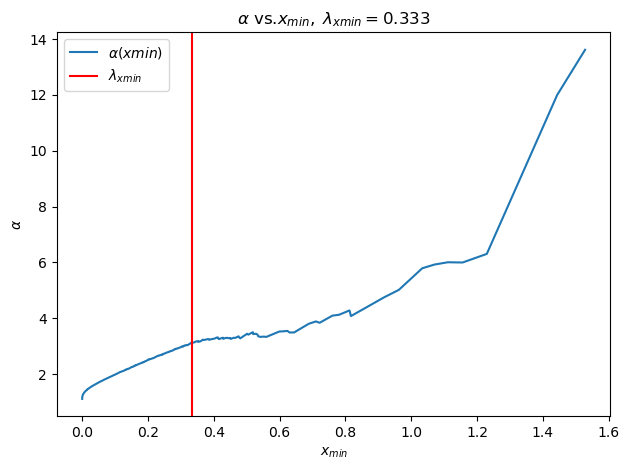

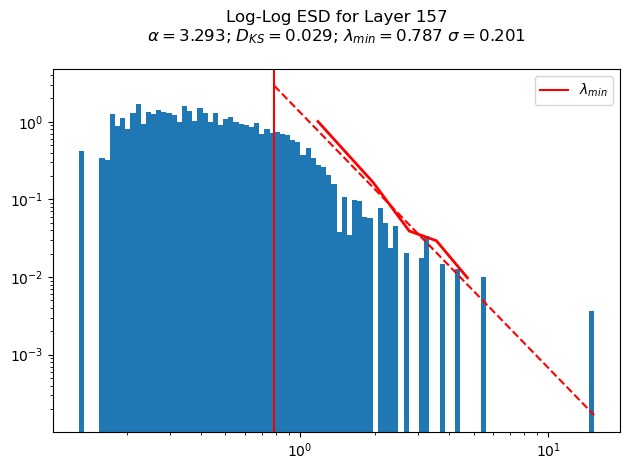

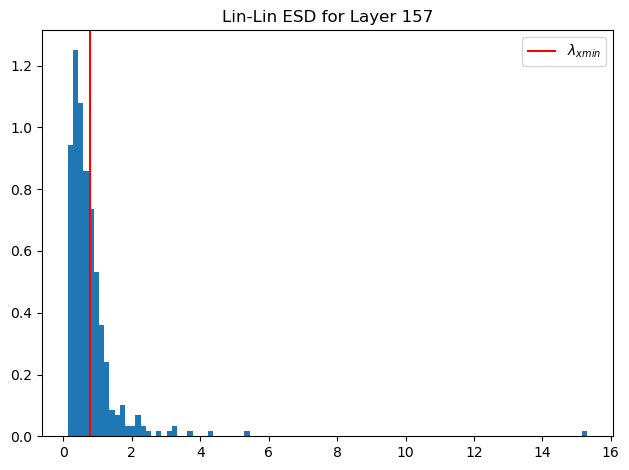

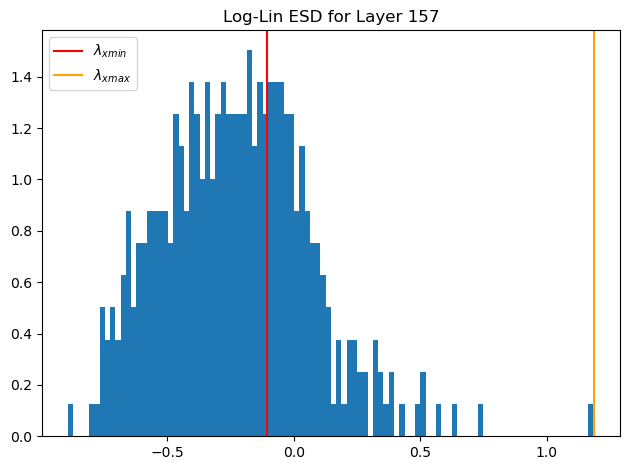

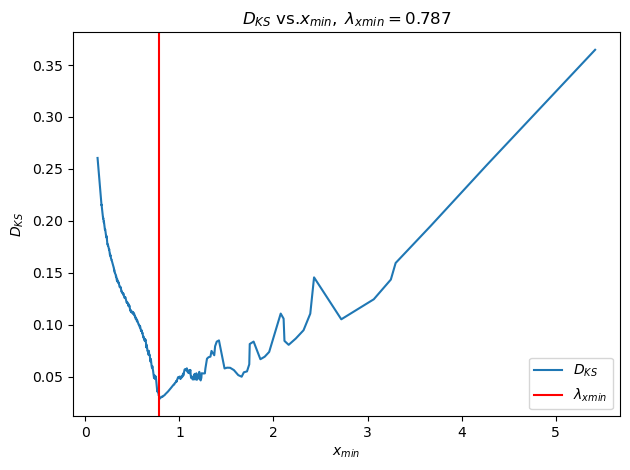

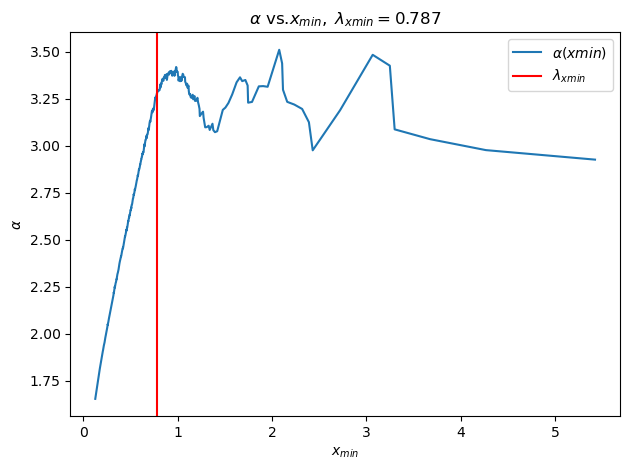

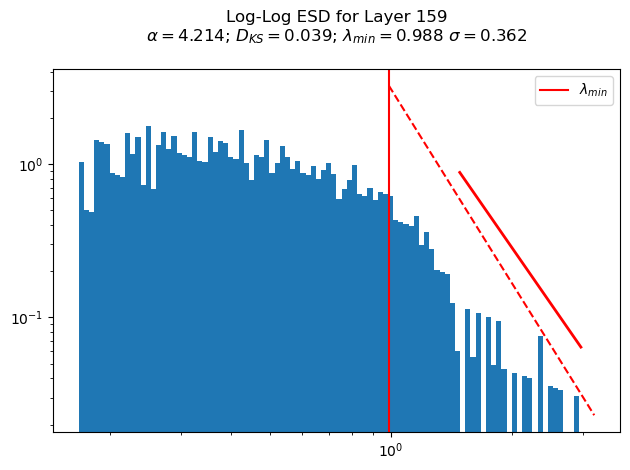

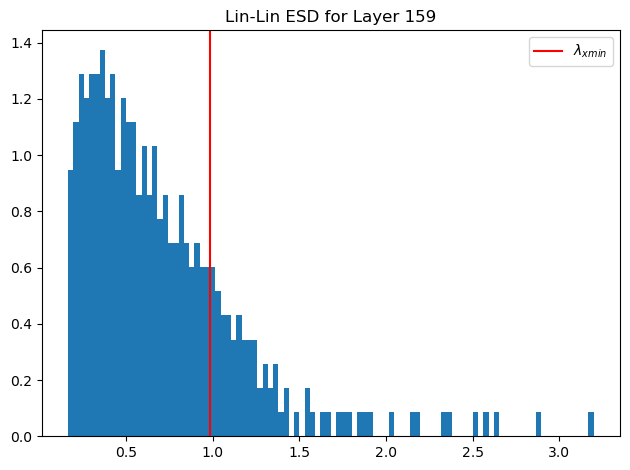

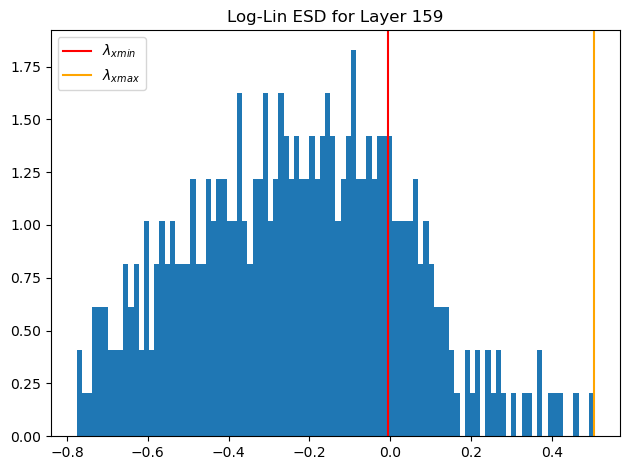

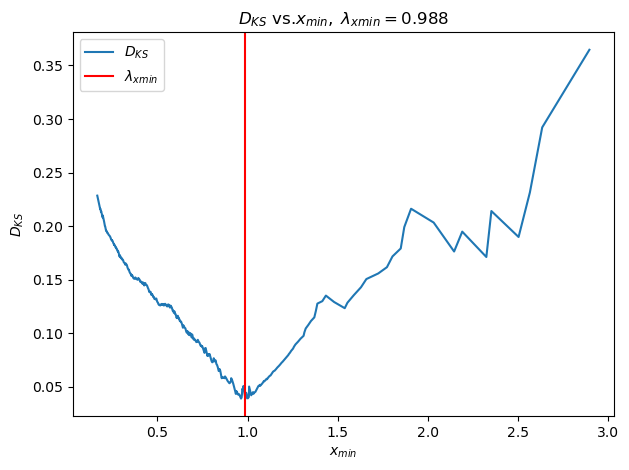

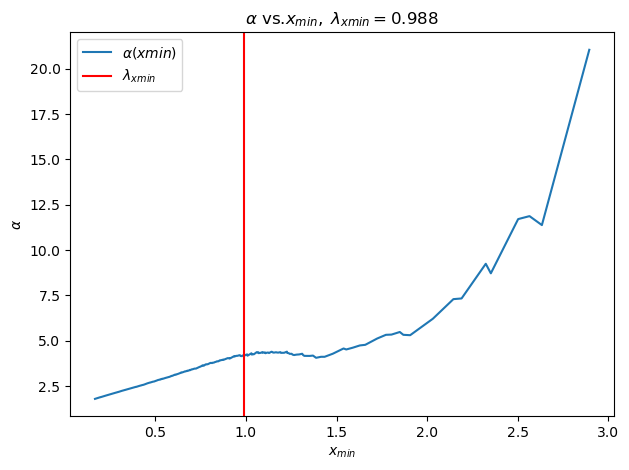

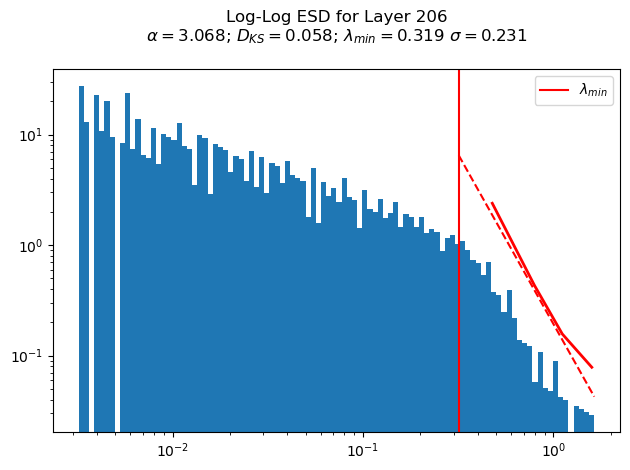

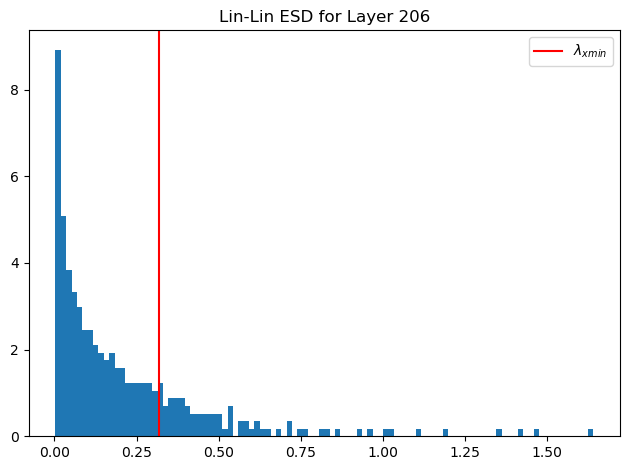

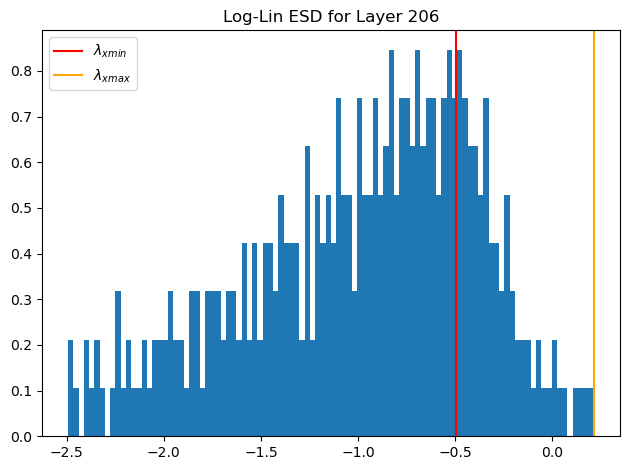

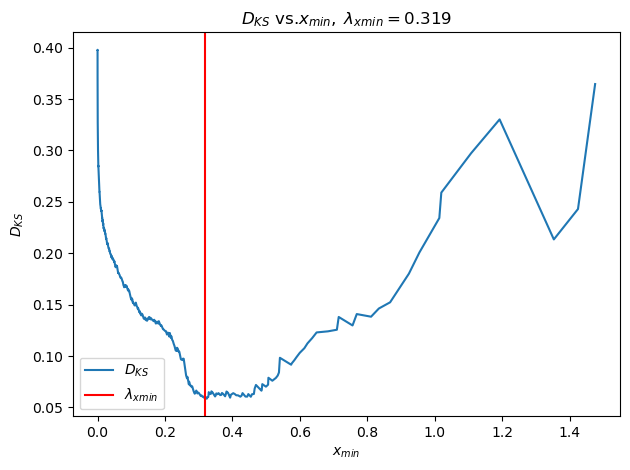

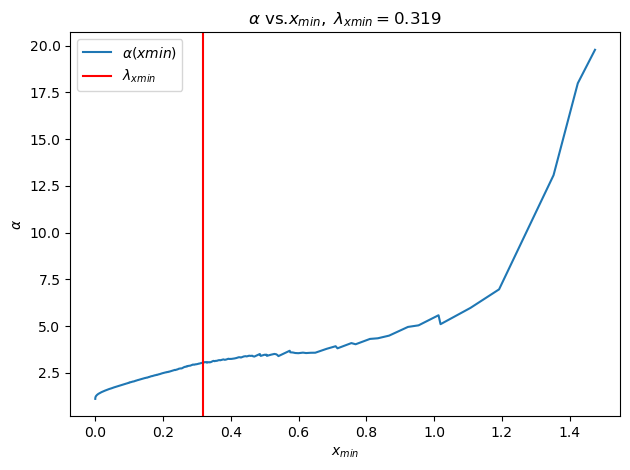

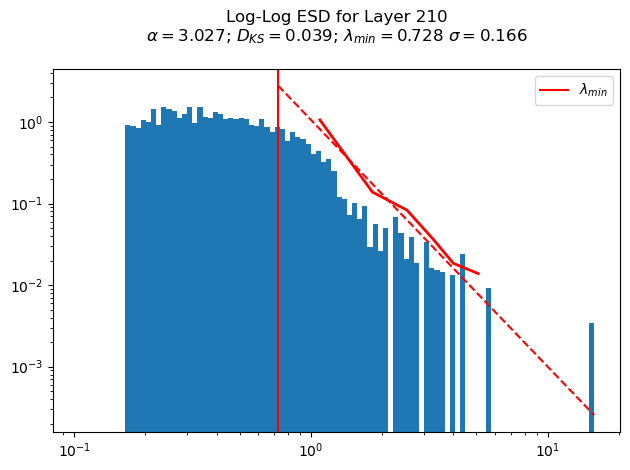

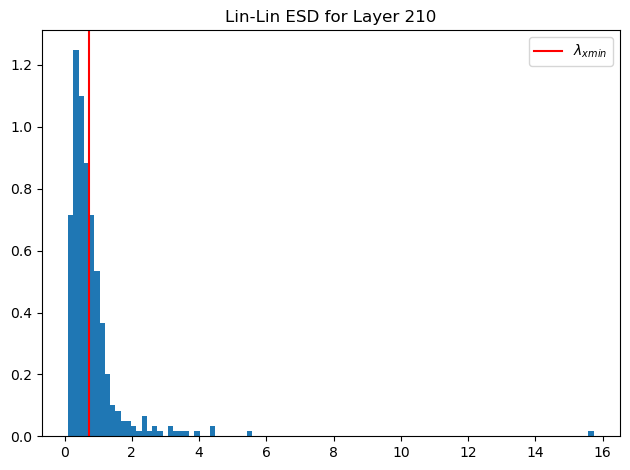

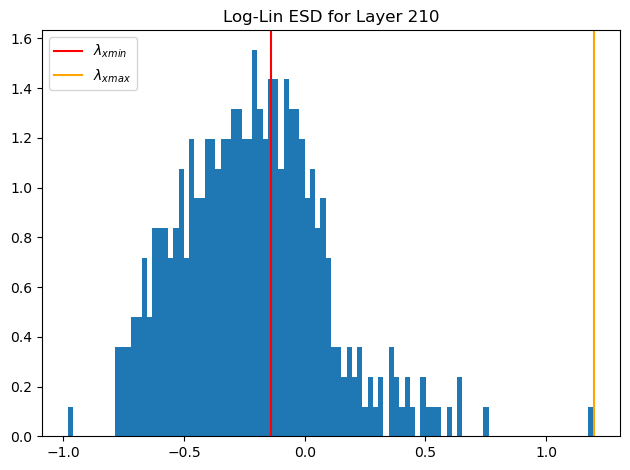

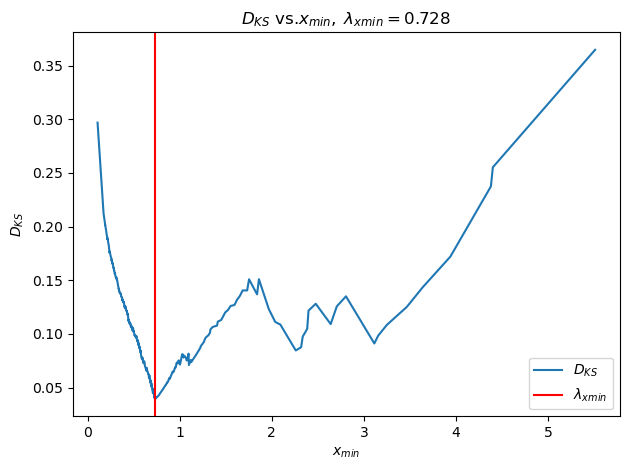

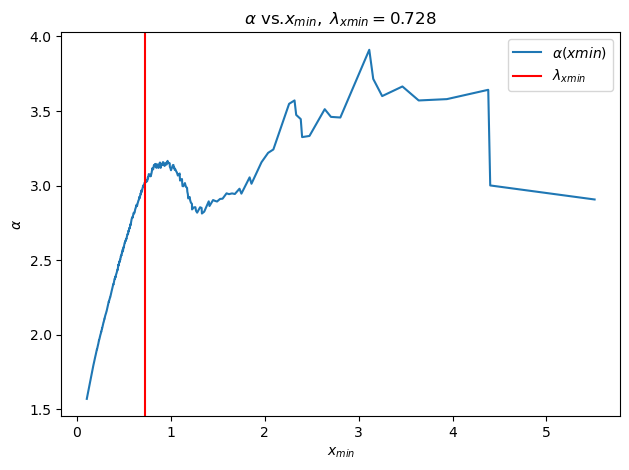

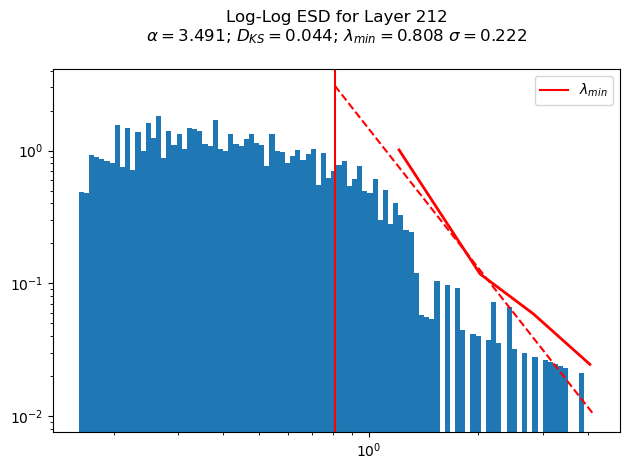

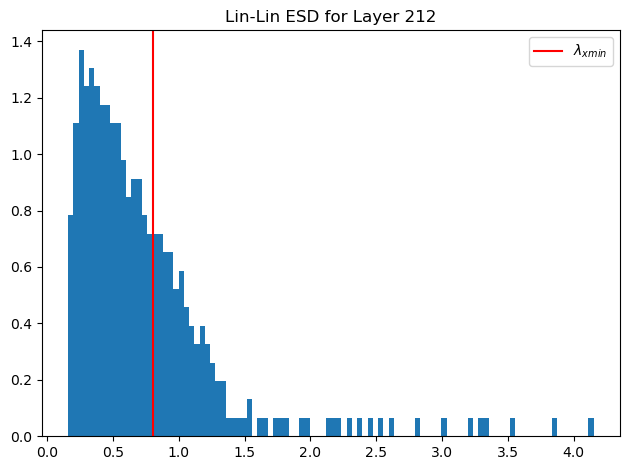

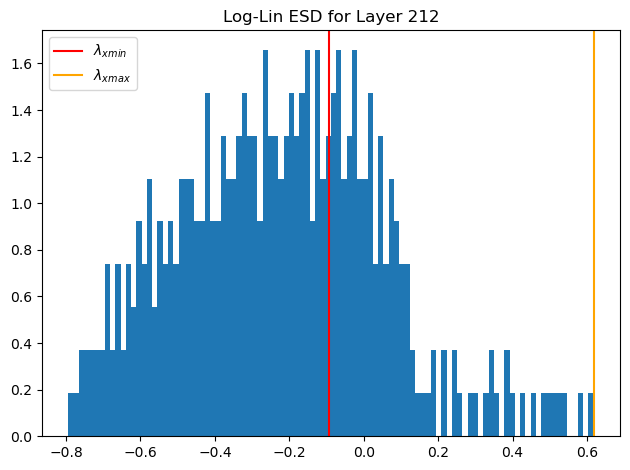

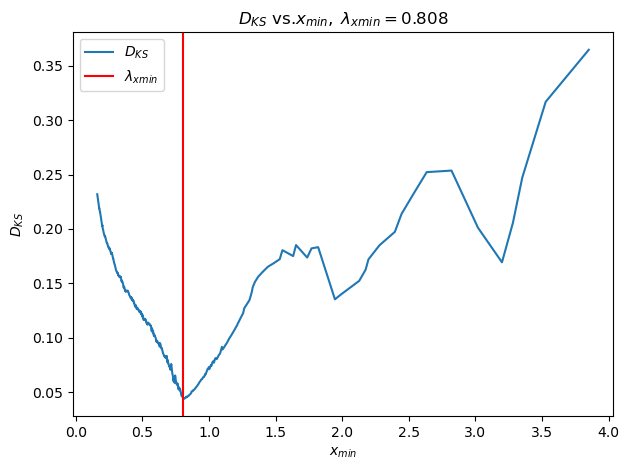

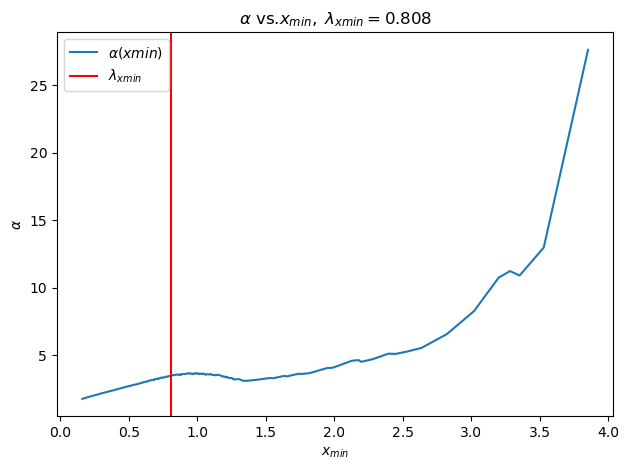

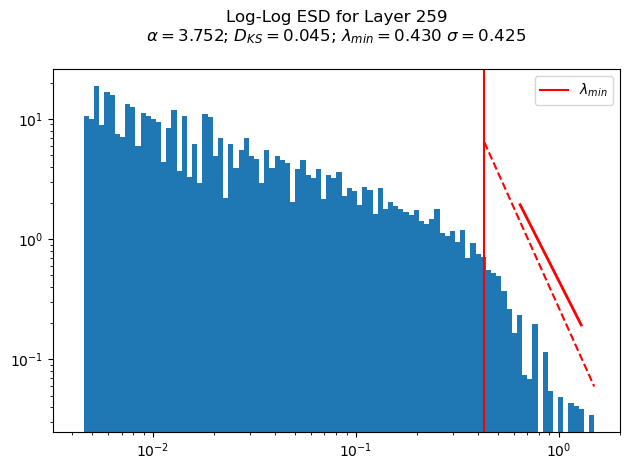

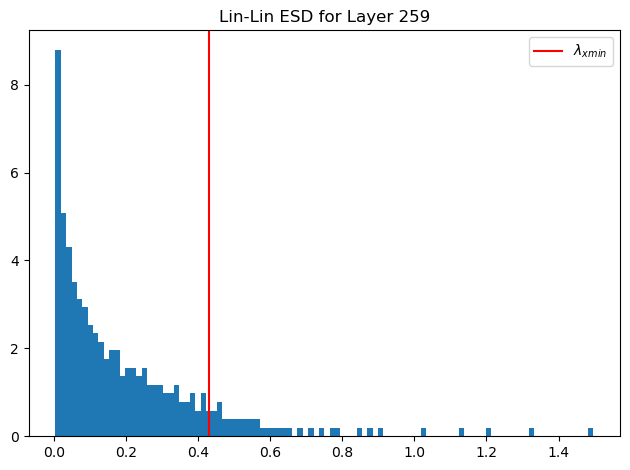

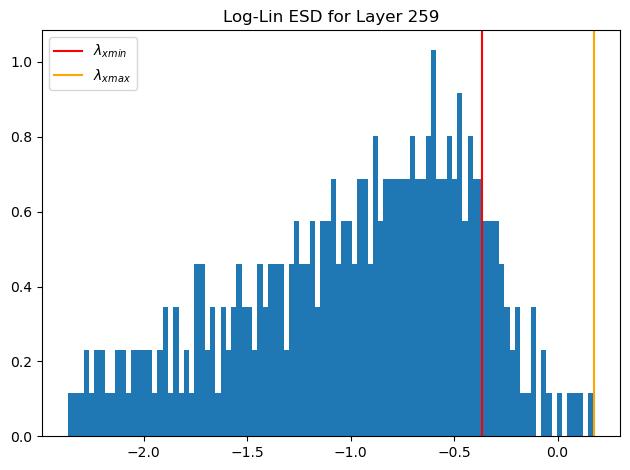

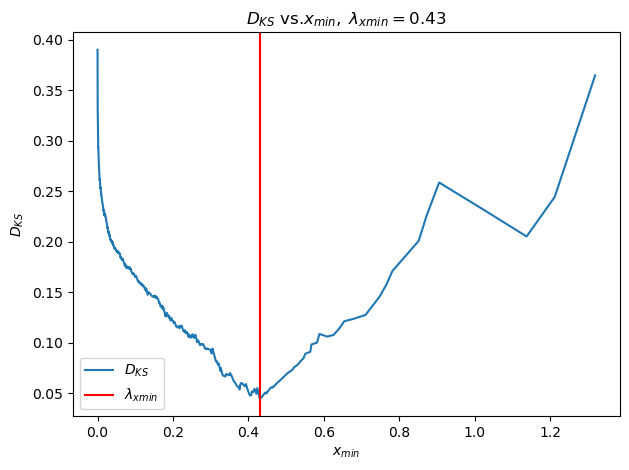

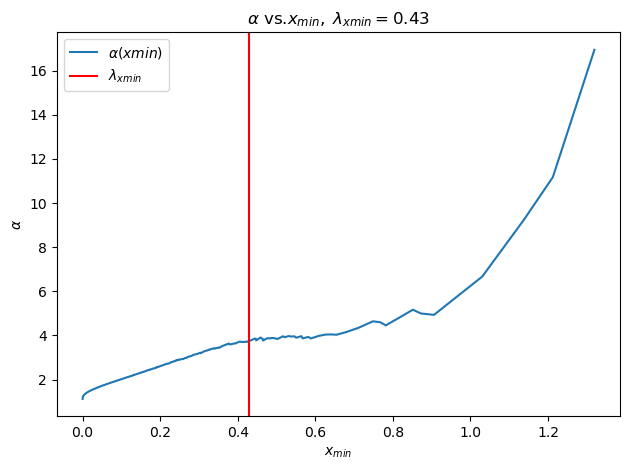

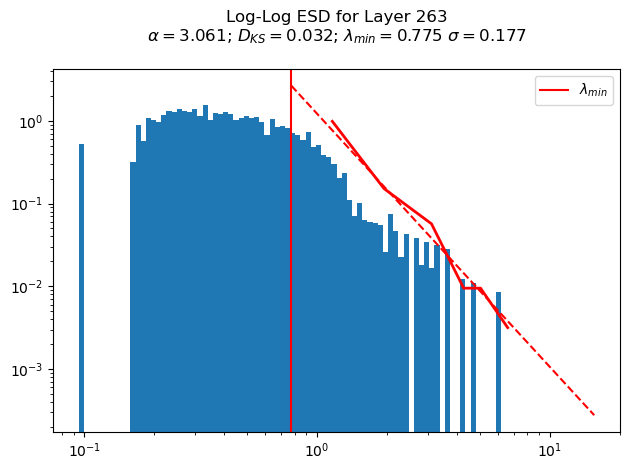

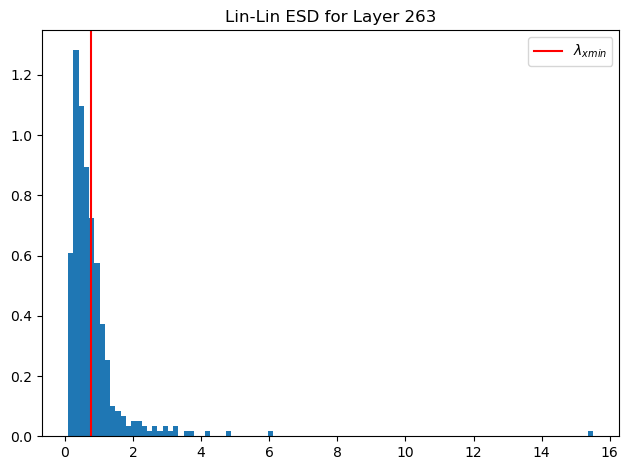

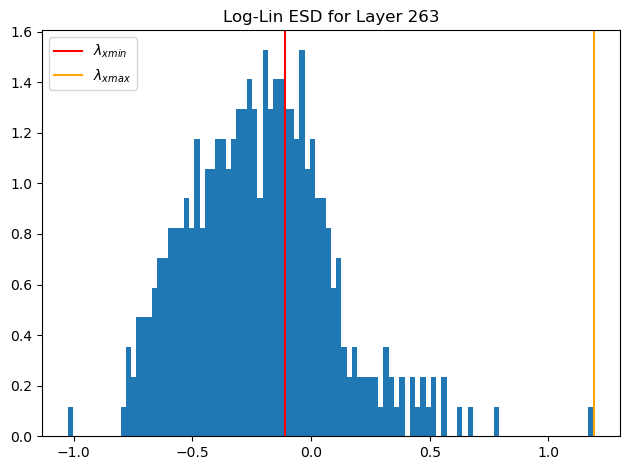

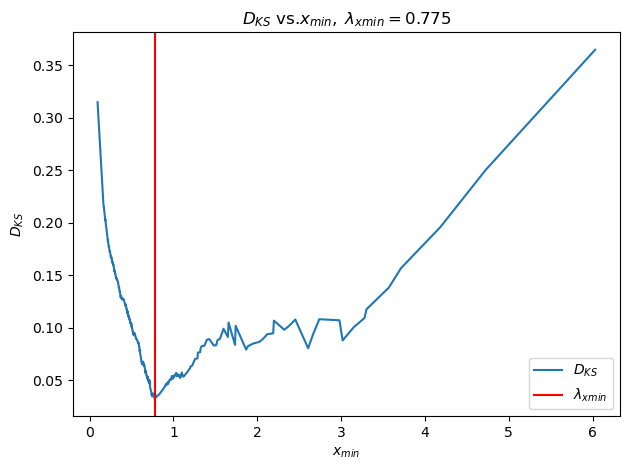

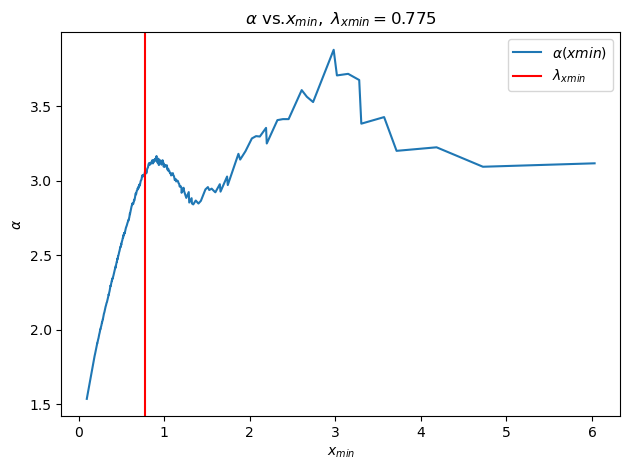

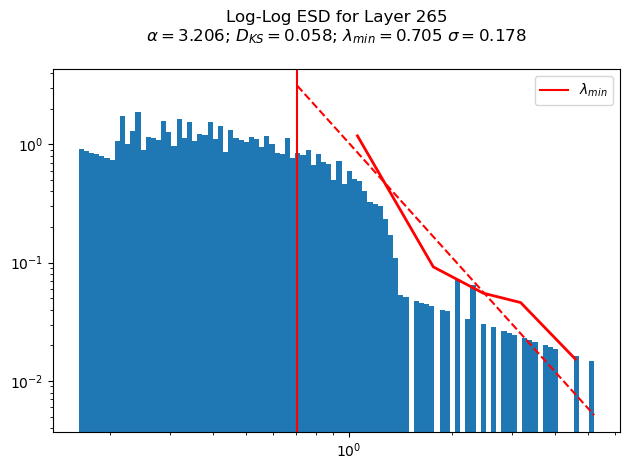

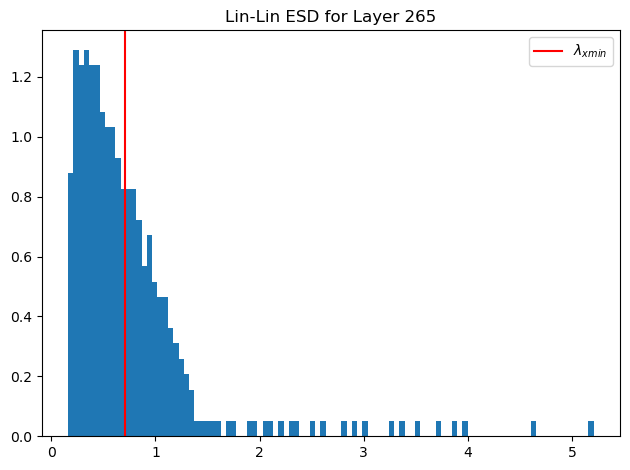

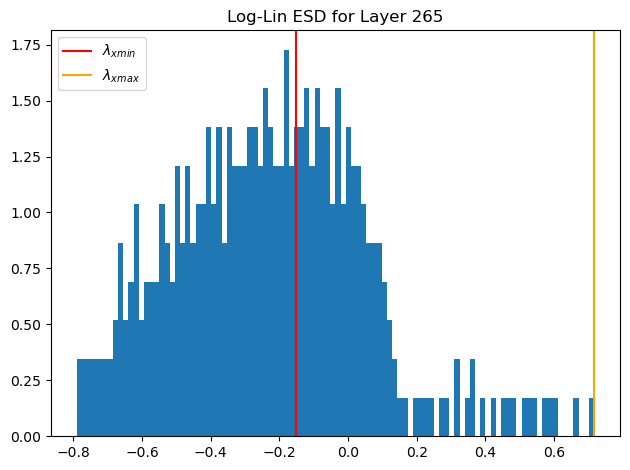

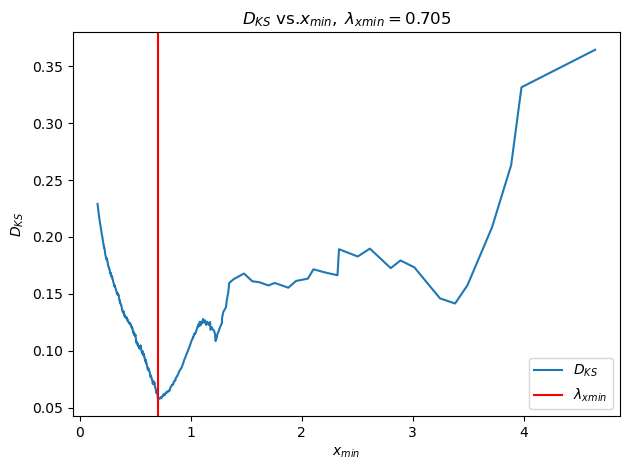

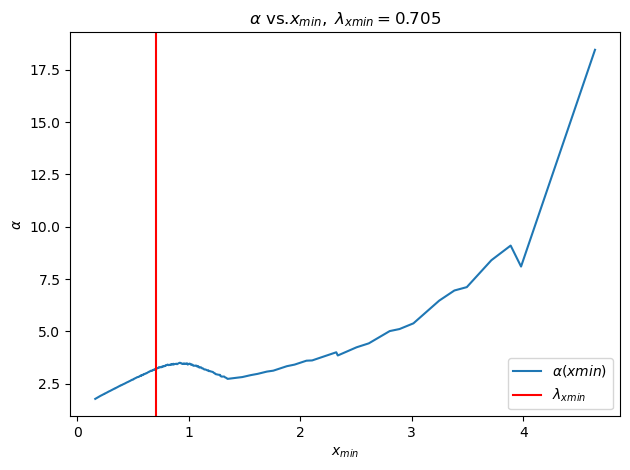

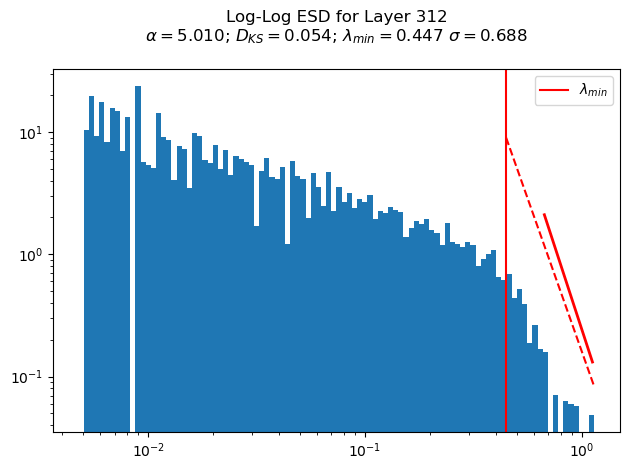

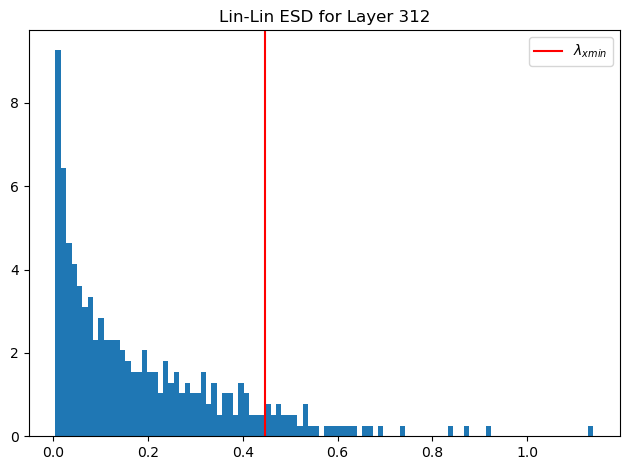

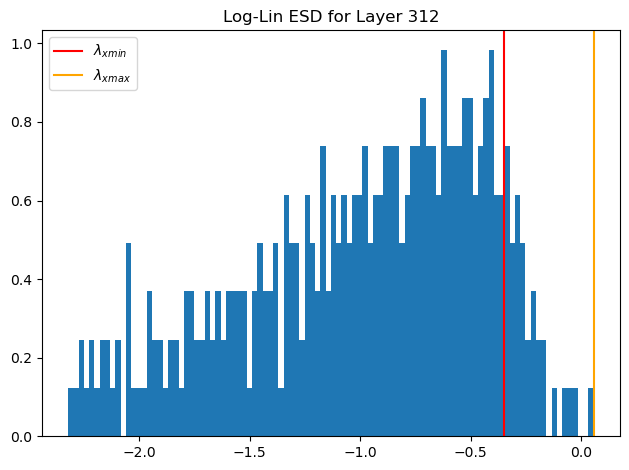

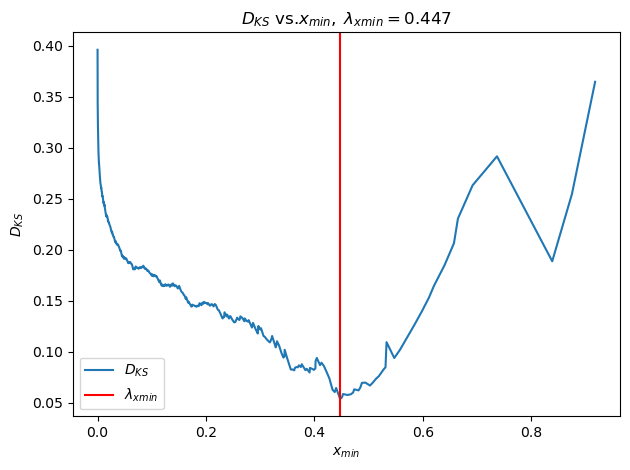

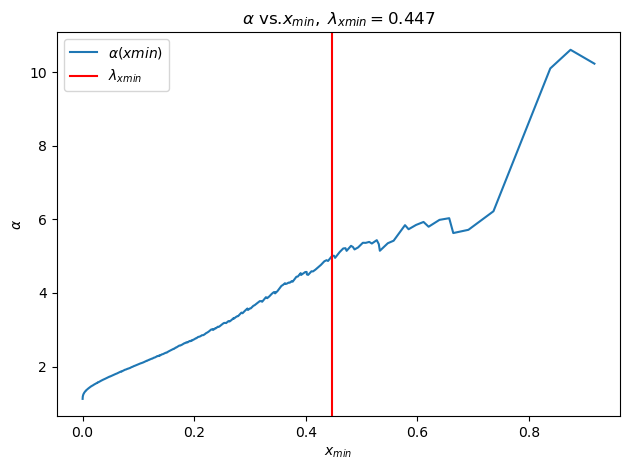

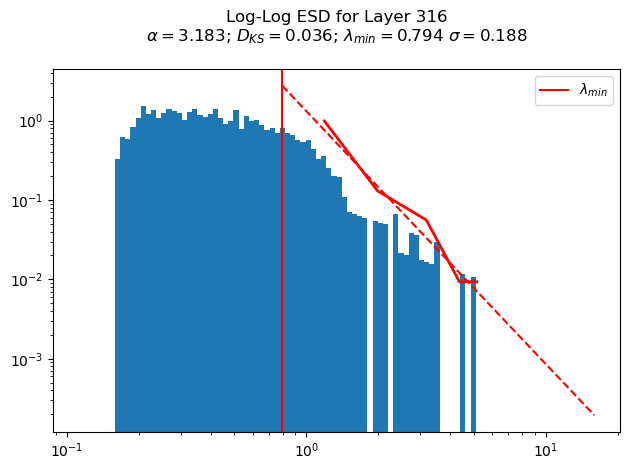

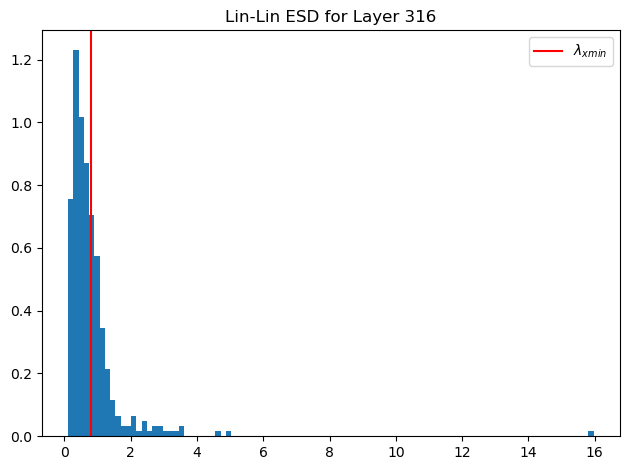

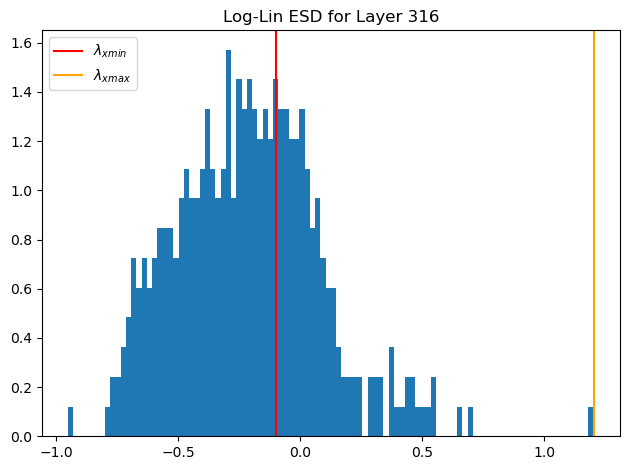

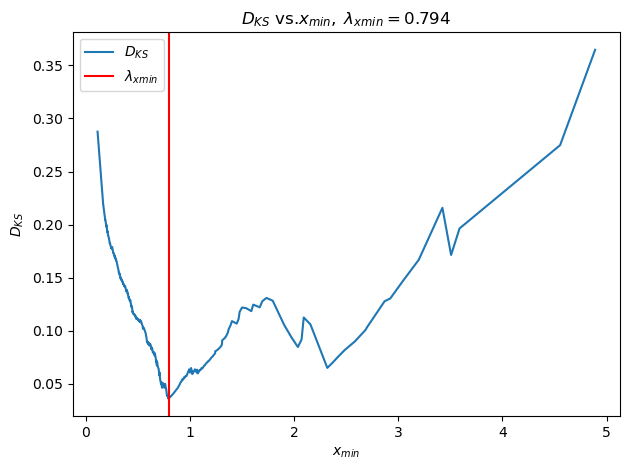

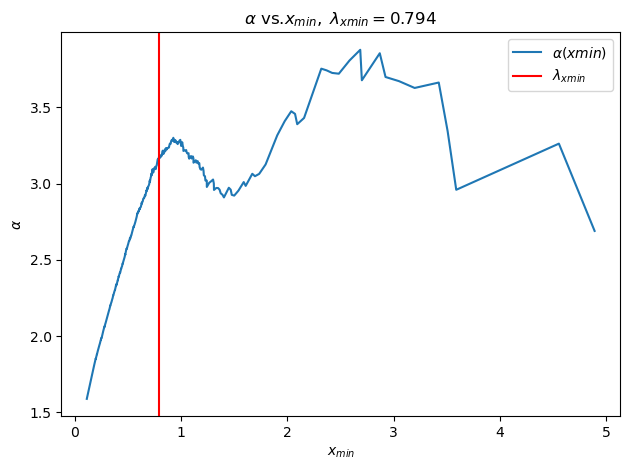

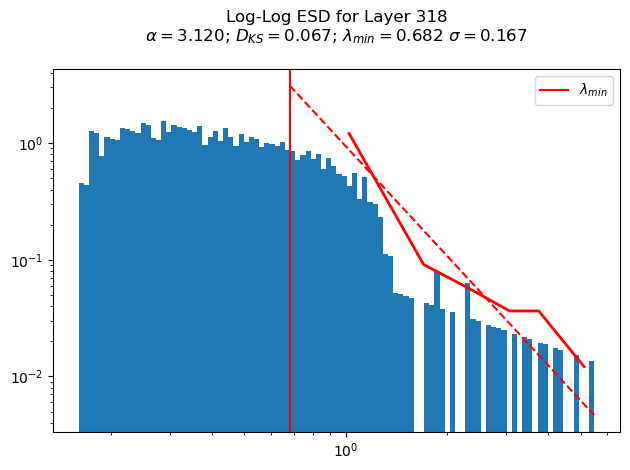

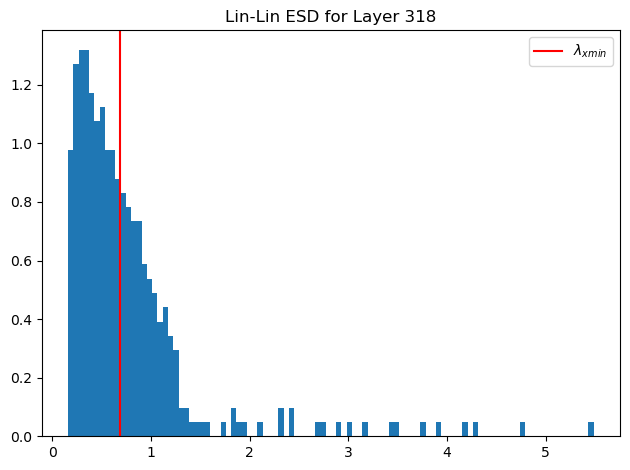

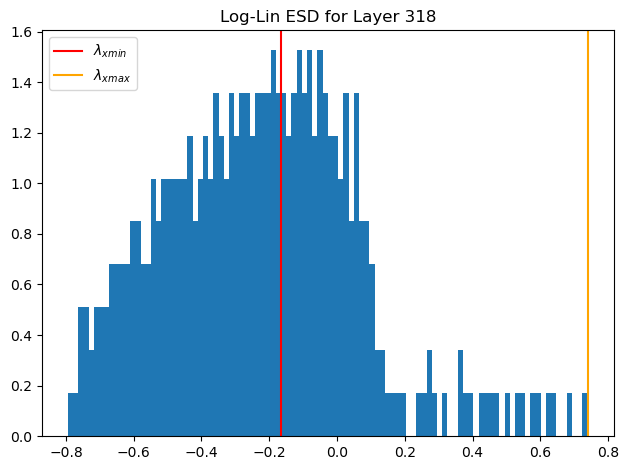

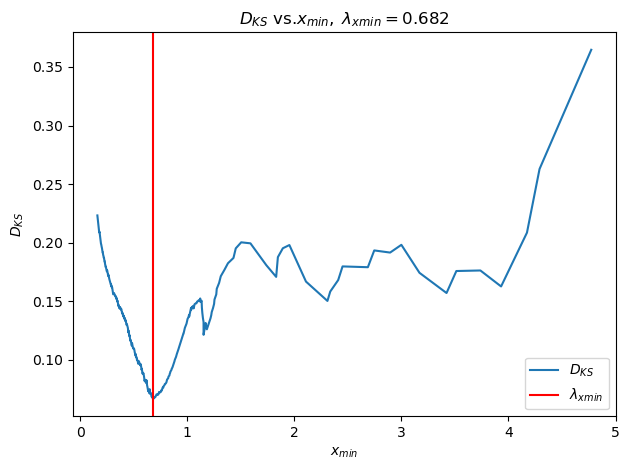

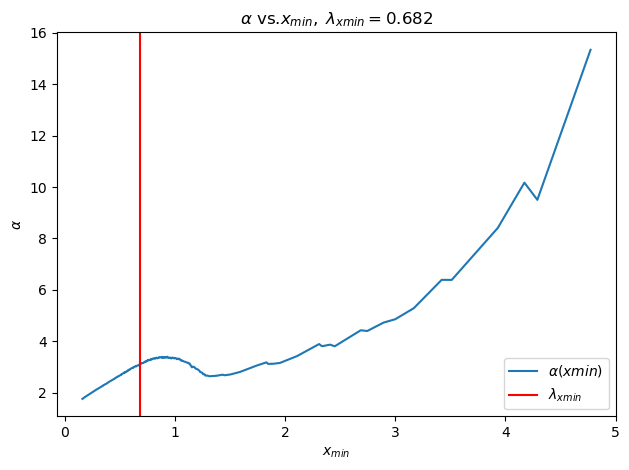

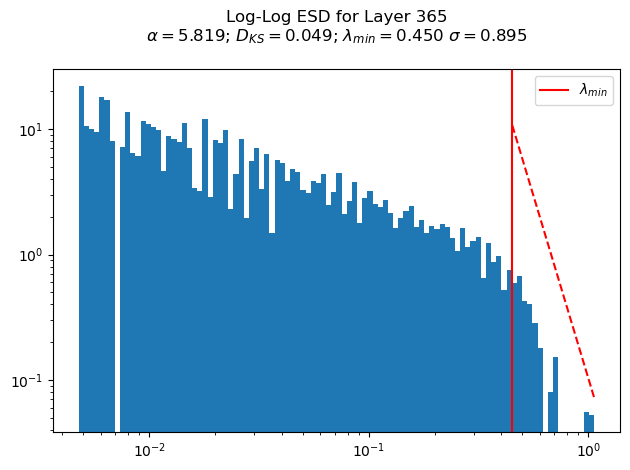

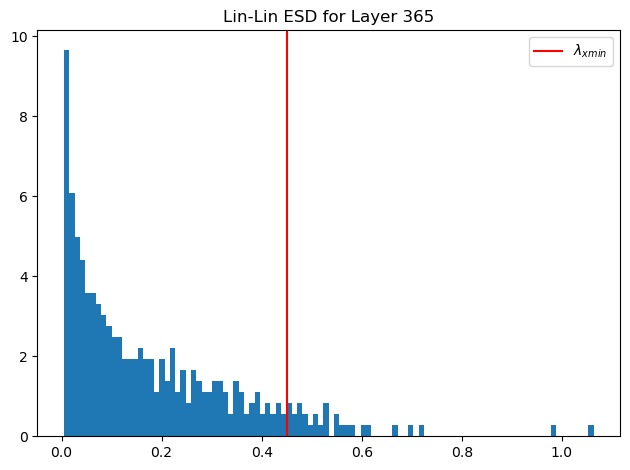

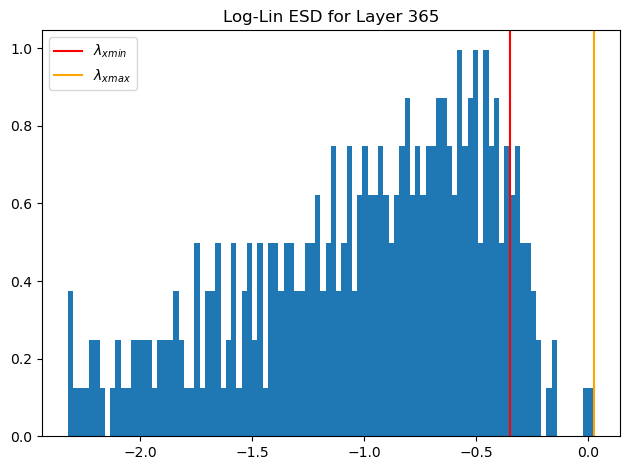

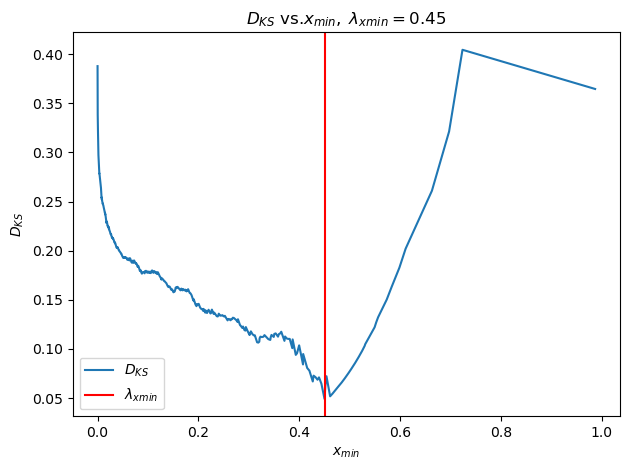

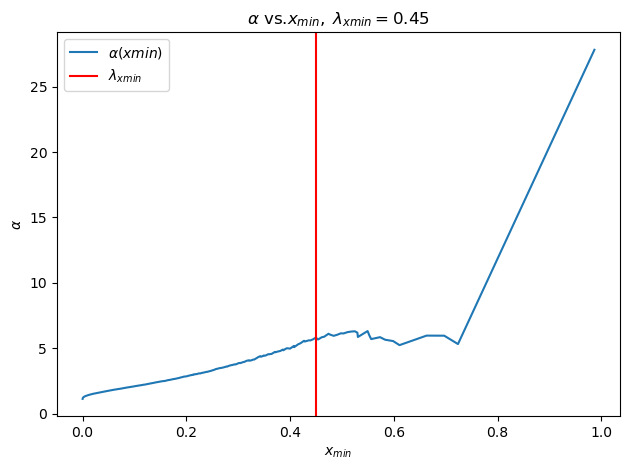

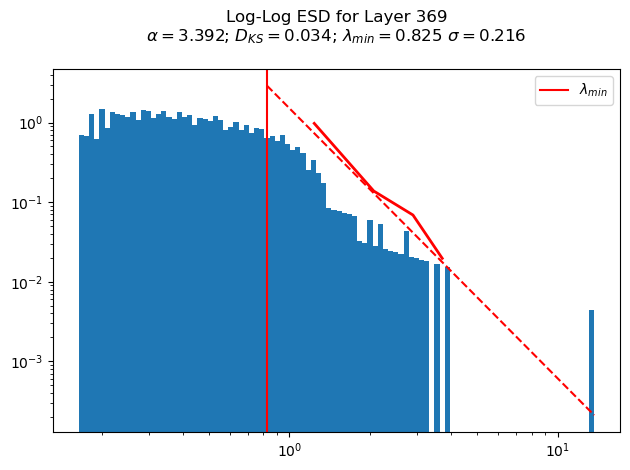

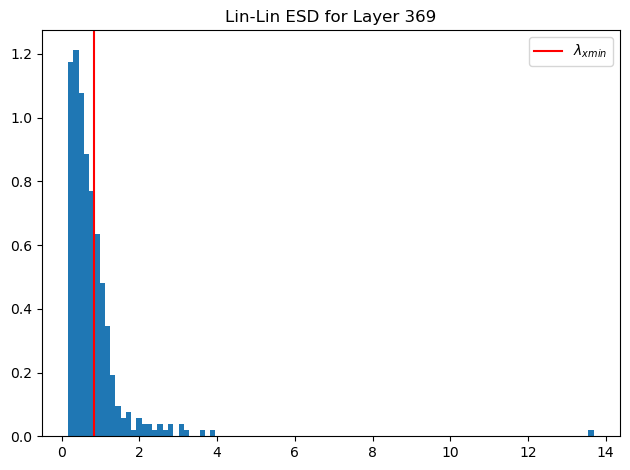

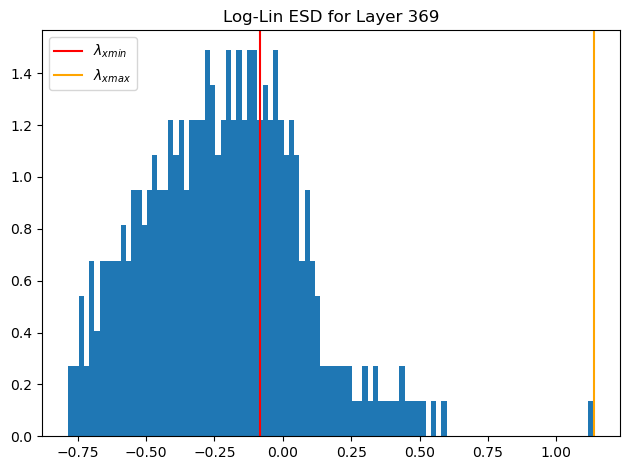

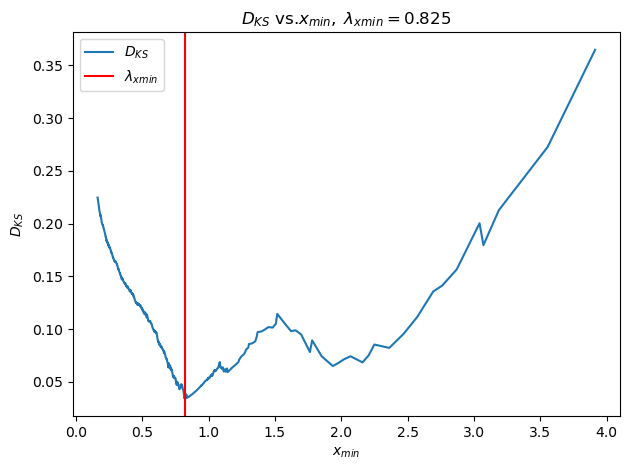

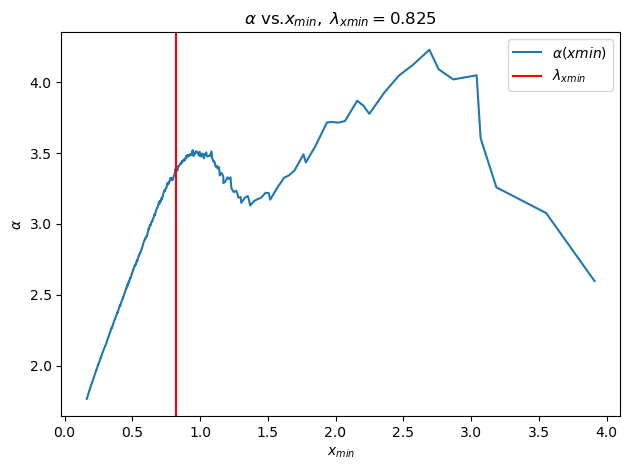

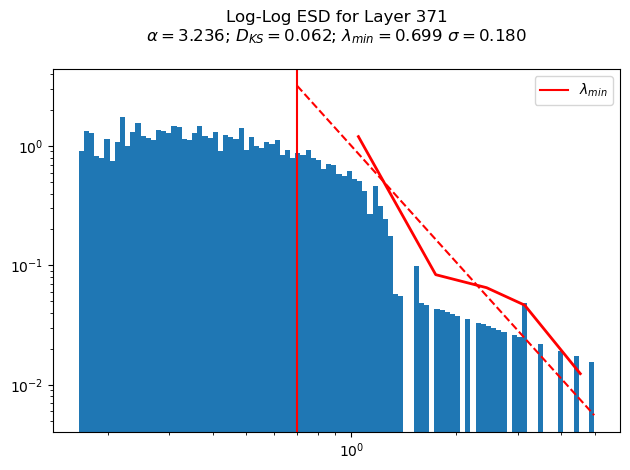

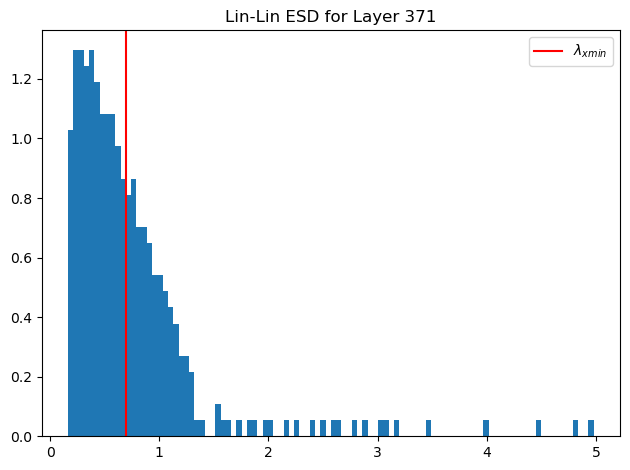

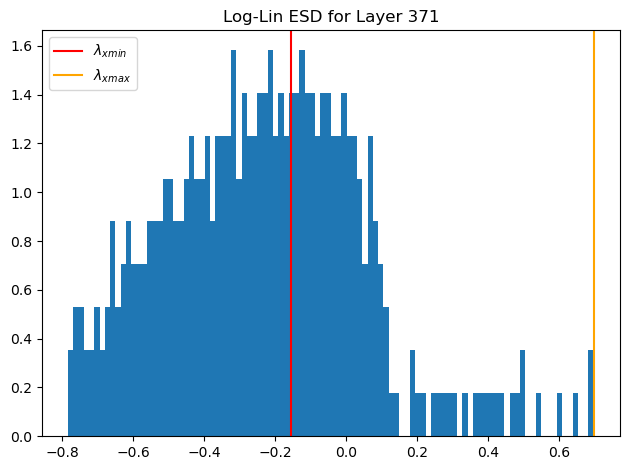

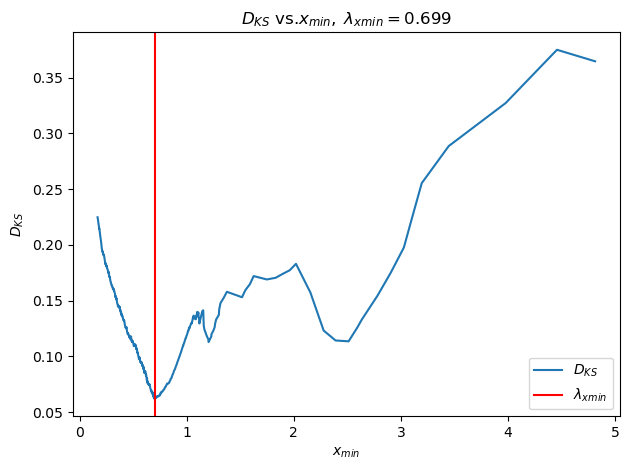

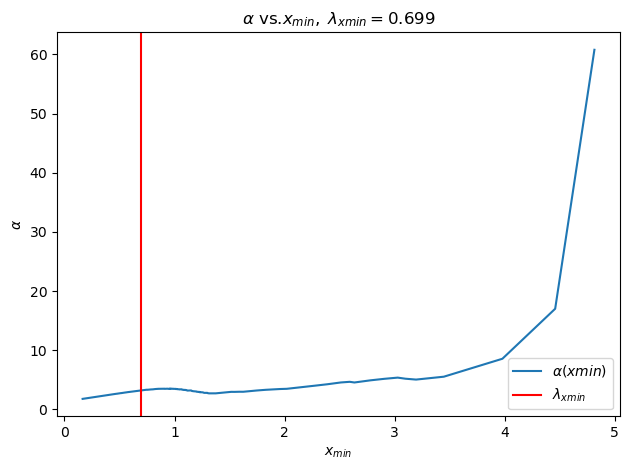

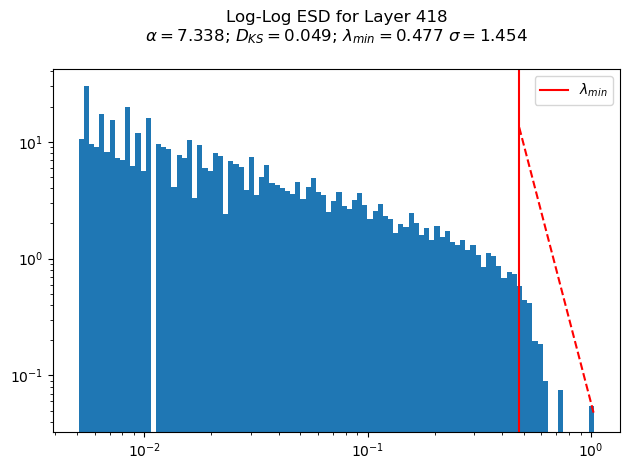

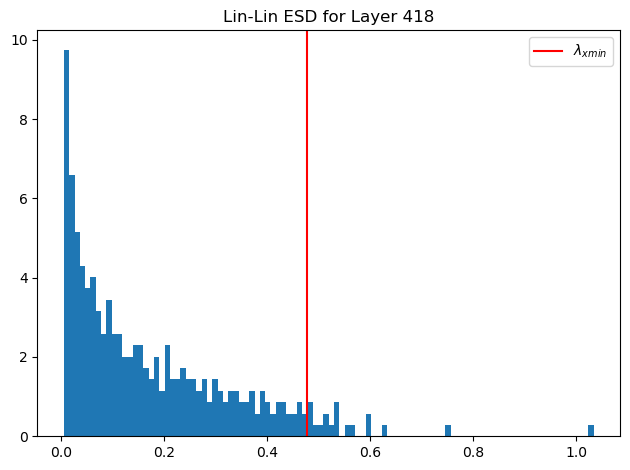

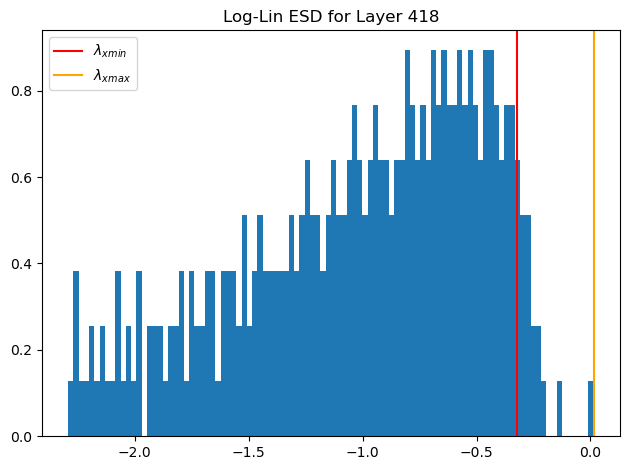

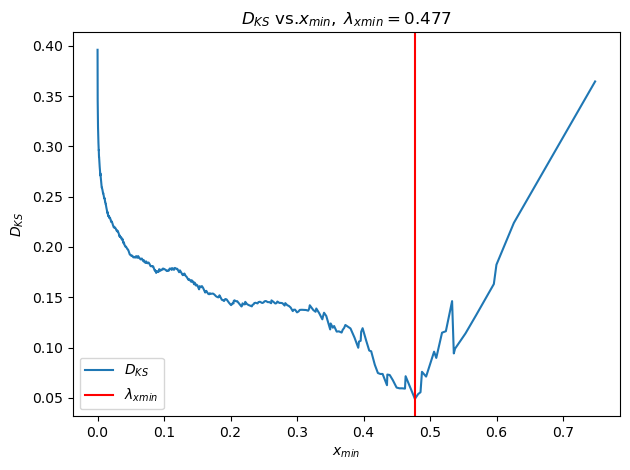

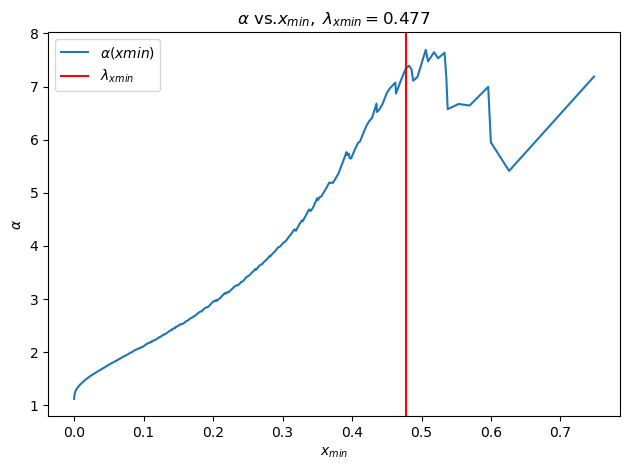

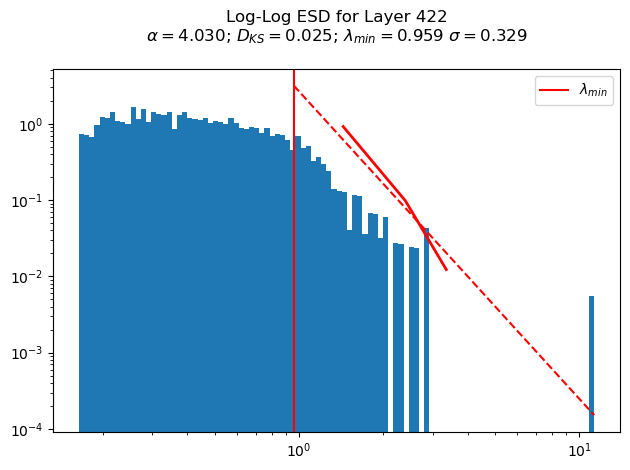

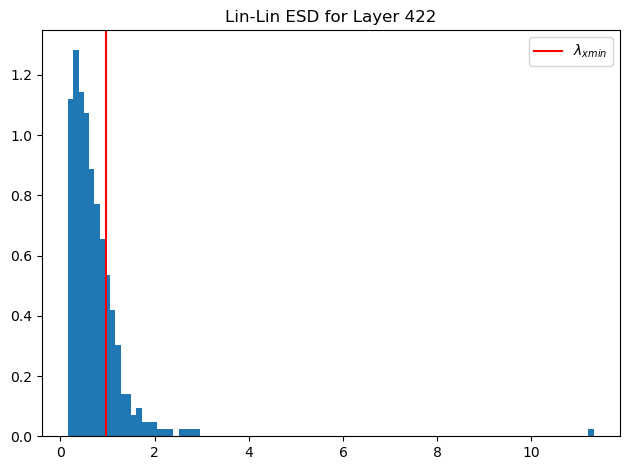

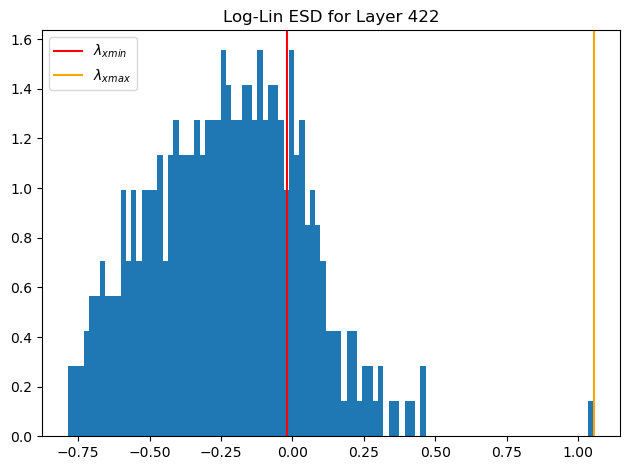

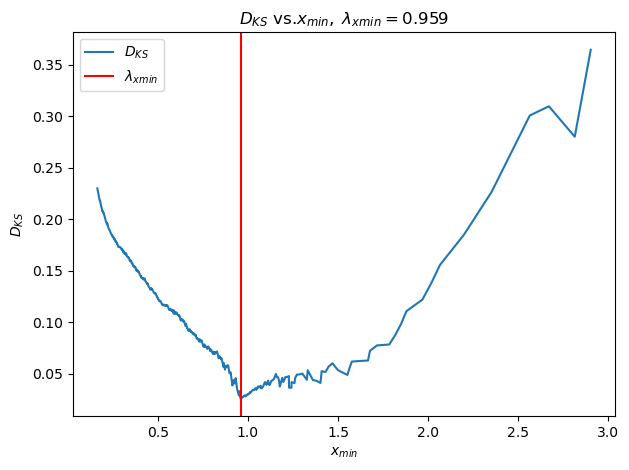

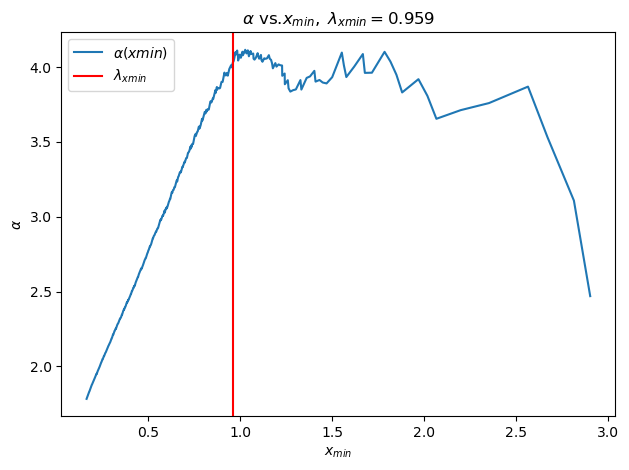

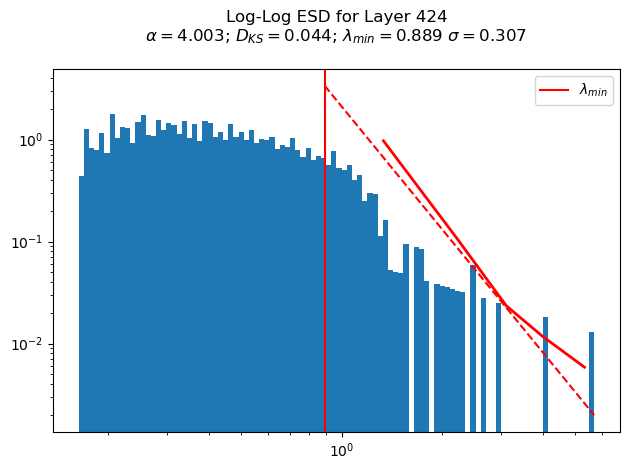

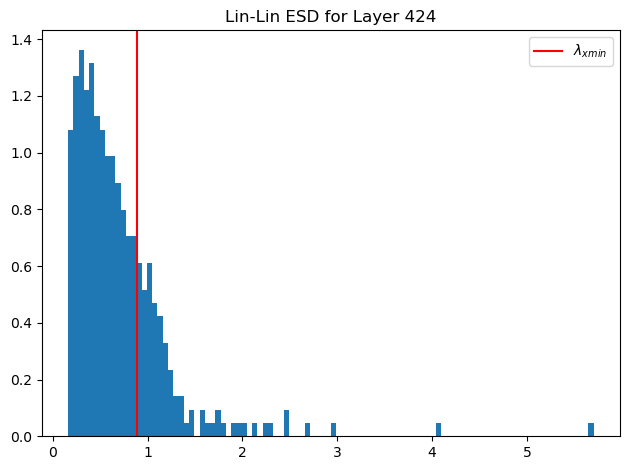

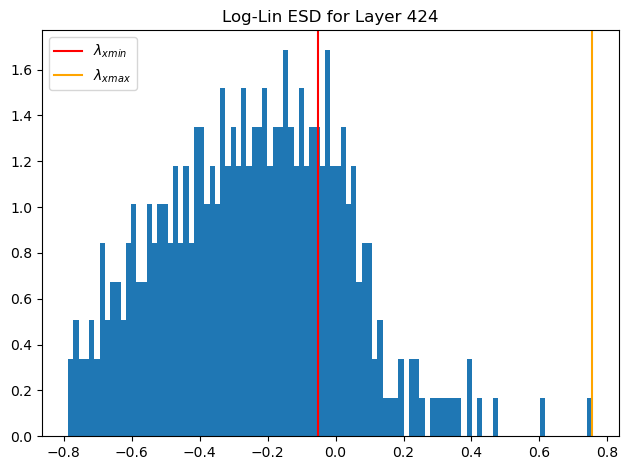

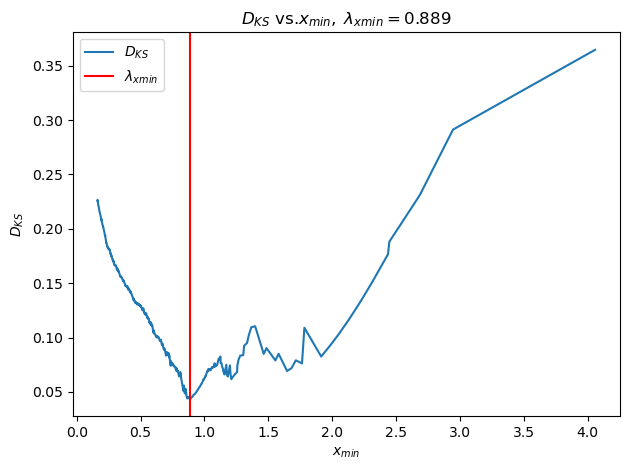

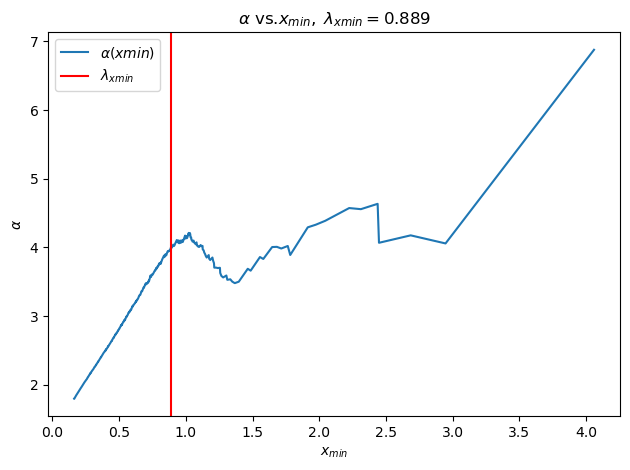

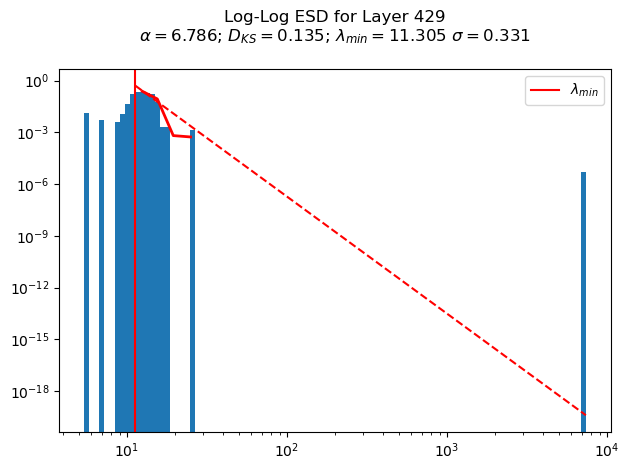

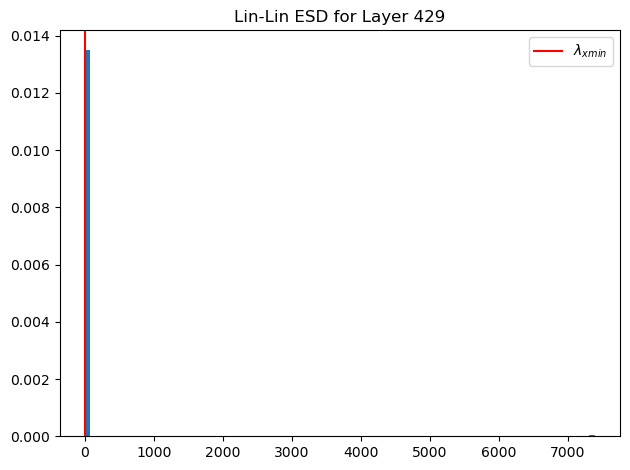

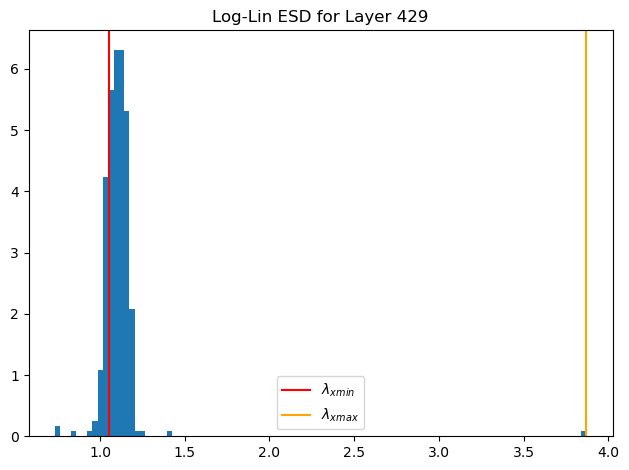

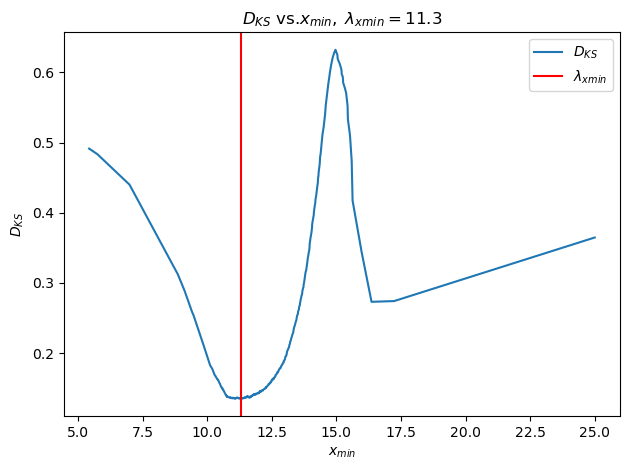

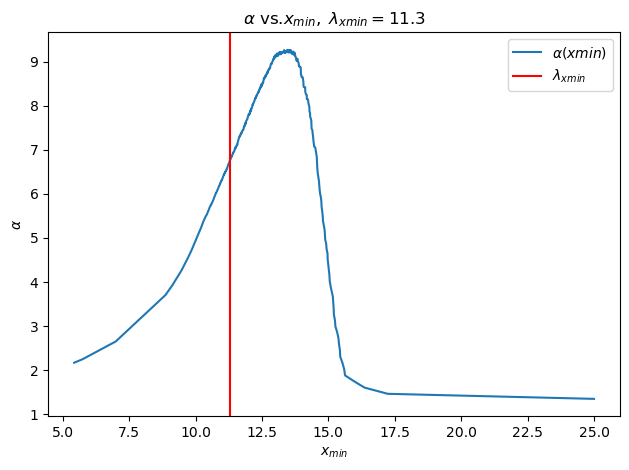


Detailed Layer Analysis:
    layer_id       name         D    M      N          Q      alpha  \
0          1  Embedding  0.083407  384  32171  83.778646  70.961860   
1          2  Embedding  0.035767  128    384   3.000000   2.687704   
2         47     Linear  0.054287  384    384   1.000000   4.685437   
3         51     Linear  0.091003  384   1536   4.000000   5.287558   
4         53     Linear  0.105763  384   1536   4.000000   9.500243   
5        100     Linear  0.047294  384    384   1.000000   2.769593   
6        104     Linear  0.027192  384   1536   4.000000   3.758605   
7        106     Linear  0.042562  384   1536   4.000000   4.980064   
8        153     Linear  0.044969  384    384   1.000000   3.141333   
9        157     Linear  0.028525  384   1536   4.000000   3.292780   
10       159     Linear  0.038706  384   1536   4.000000   4.214328   
11       206     Linear  0.058289  384    384   1.000000   3.068500   
12       210     Linear  0.039440  384   1536   4.0

KeyError: 'mp_softrank'

<Figure size 640x480 with 0 Axes>

In [19]:
details, summary = analyze_model_weights(m)